## Data Ingest

In [ ]:
import networkx as nx
import csv  
import pandas as pd
import matplotlib.pyplot as plt
import os 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# change to working tensorflow directory on the drive
%cd '/content/gdrive/My Drive/TF/models'

Mounted at /content/gdrive
/content/gdrive/My Drive/TF/models


In [ ]:
# ARROWS_PATH_BPNM = "/content/gdrive/My Drive/TF/models/research/object_detection/outputs_arrow_rcnn/bpnm/"
# ENTITIES_PATH_BPNM = "/content/gdrive/My Drive/TF/models/research/object_detection/outputs_rcnn/bpnm/"
# ARROWS_PATH_SWIMLANE = "/content/gdrive/My Drive/TF/models/research/object_detection/outputs_arrow_rcnn/swimlane/"
# ENTITIES_PATH_SWIMLANE = "/content/gdrive/My Drive/TF/models/research/object_detection/outputs_rcnn/swimlane/"

# ARROWS_FILES_BPNM = os.listdir(ARROWS_PATH_BPNM)
# ENTITIES_FILES_BPNM = os.listdir(ENTITIES_PATH_BPNM)
# ARROWS_FILES_SWIMLANE = os.listdir(ARROWS_PATH_SWIMLANE)
# ENTITIES_FILES_SWIMLANE = os.listdir(ENTITIES_PATH_SWIMLANE)

# ARROWS_FILES_BPNM.sort()
# ENTITIES_FILES_BPNM.sort()
# ARROWS_FILES_SWIMLANE.sort()
# ENTITIES_FILES_SWIMLANE.sort()

CBD_PATH = "/content/gdrive/My Drive/TF/models/research/object_detection/outputs/"
CBD_FILES = os.listdir(CBD_PATH)

In [ ]:
label_color_map = {
    'process': 'blue',
    'terminator': 'green',
    'decision': 'red'
}

label_shape_map = {
    'process': '^',
    'terminator': 'o',
    'decision': 'd'
}

In [ ]:
# bpnm_files = []
# for i in range(len(ARROWS_FILES_BPNM)):
#   curr = ARROWS_FILES_BPNM[i]
#   if(curr.endswith(".csv")):
#     bpnm_files.append([curr])

# count = 0
# for i in range(len(ENTITIES_FILES_BPNM)):
#   curr = ENTITIES_FILES_BPNM[i]
#   if(curr.endswith(".csv")):
#     bpnm_files[count].append(curr)
#     count += 1
    
# swimlane_files = []
# for i in range(len(ARROWS_FILES_SWIMLANE)):
#   curr = ARROWS_FILES_SWIMLANE[i]
#   if(curr.endswith(".csv")):
#     swimlane_files.append([curr])

# count = 0
# for i in range(len(ENTITIES_FILES_SWIMLANE)):
#   curr = ENTITIES_FILES_SWIMLANE[i]
#   if(curr.endswith(".csv")):
#     swimlane_files[count].append(curr)
#     count += 1

files = []
gml = []
for i in range(len(CBD_FILES)):
  curr = CBD_FILES[i]
  if curr.endswith(".csv"):
    files.append(curr)
  elif curr.endswith(".gml"):
    gml.append(curr)

## Utility Functions


In [ ]:
def get_cord_of_intersecting_rectangles(x_bbox, y_bbox):
  x_xmin, x_ymin, x_xmax, x_ymax = x_bbox
  y_xmin, y_ymin, y_xmax, y_ymax = y_bbox

  xmin   = max(x_xmin, y_xmin)
  ymin    = max(x_ymin, y_ymin)
  xmax  = min(x_xmax, y_xmax)
  ymax = min(x_ymax, y_ymax)
  
  return (xmin, ymin, xmax, ymax)

# xmin, ymin, xmax, ymax, node_xmin, node_ymin, node_xmax, node_ymax
def intersection(x_bbox, y_bbox):
  # Calculate intersecting boundaries
  xmin, ymin, xmax, ymax = get_cord_of_intersecting_rectangles(x_bbox, y_bbox)
  if xmin < xmax and ymin < ymax: 
    return True
  return False

def get_iou_score(x_bbox, y_bbox):
  xmin, ymin, xmax, ymax = get_cord_of_intersecting_rectangles(x_bbox, y_bbox)
  intersection_area = (xmax - xmin) * (ymax - ymin)
  x_bbox_area = (x_bbox[2] - x_bbox[0]) * (x_bbox[3] - x_bbox[1])
  y_bbox_area = (y_bbox[2] - y_bbox[0]) * (y_bbox[3] - y_bbox[1])

  iou = intersection_area / float(x_bbox_area + y_bbox_area - intersection_area)
  return iou

def jaccard_similarity(g, h):
  i = set(g).intersection(h)
  return round(len(i) / (len(g) + len(h) - len(i)),3)

def get_union(G, B):
  G_union = nx.compose(G, B)

  edge_colors = dict()
  for edge in G_union.edges():
      if G.has_edge(*edge):
          if B.has_edge(*edge):
              edge_colors[edge] = '#77DD77'
              continue
          edge_colors[edge] = '#FF6961'
      elif B.has_edge(*edge):
          edge_colors[edge] = '#ADD8E6'
  G_nodes = set(G.nodes())
  B_nodes = set(B.nodes())
  node_colors = []
  for node in G_union.nodes():
      if node in G_nodes:
          if node in B_nodes:
              node_colors.append('#77DD77')
              continue
          node_colors.append('#FF6961')
      if node in B_nodes:
          node_colors.append('#ADD8E6')

  return (G_union, node_colors, edge_colors)

## Method 1


In [ ]:
nx_objs = []

for i in files:
  file = pd.read_csv(CBD_PATH + i)
  pd_arrow, pd_entity = [], []

  for index, row in file.iterrows():
    entity_class = row["class"]
    if entity_class == "arrow":
      pd_arrow.append((index, row))
    else:
      pd_entity.append((index, row))

  G = nx.Graph()
  entities = {}
  for index, row in pd_entity:
    entity_class = row["class"]
    ymin, ymax = row["ymin"], row["ymax"]
    xmin, xmax = row["xmin"], row["xmax"]
    name = entity_class + "_" + str(index)
    G.add_node(name, color=label_color_map[entity_class], node_shape=label_shape_map[entity_class], style='filled',fillcolor='blue')
    entities[name] = (ymin, xmin, ymax, xmax)

  all_edges = []
  for index, row in pd_arrow:
    entity_class = row["class"]
    ymin, ymax = row["ymin"], row["ymax"]
    xmin, xmax = row["xmin"], row["xmax"]
    curr_edge = []  
    for node in entities.keys():
      bbox = entities[node]
      node_ymin, node_ymax = bbox[0], bbox[2]
      node_xmin, node_xmax = bbox[1], bbox[3]
      found = False

      if intersection((xmin, ymin, xmax, ymax), (node_xmin, node_ymin, node_xmax, node_ymax)): 
        # found = True 
        curr_edge.append(node)

      # if found: 
      #   if len(curr_edge) == 2:
      #     sto_0, sto_1 = curr_edge[0], curr_edge[1]
      #     all_edges.append(curr_edge)
      #     all_edges.append([sto_0, node])
      #     all_edges.append([sto_1, node])
      #     curr_edge = []
      #   else: 
      #     curr_edge.append(node)
    
    if(len(curr_edge) == 2): all_edges.append(curr_edge)
  G.add_edges_from(all_edges)
  nx_objs.append((i,G))

## Method 2


In [ ]:
def get_potential_nodes(entities, arrow_bbox):
  potential_nodes = []  
  for node in entities.keys():
    bbox = entities[node]
    node_ymin, node_ymax = bbox[0], bbox[2]
    node_xmin, node_xmax = bbox[1], bbox[3]
    
    if intersection((xmin, ymin, xmax, ymax), (node_xmin, node_ymin, node_xmax, node_ymax)): 
      potential_nodes.append(node)
  return potential_nodes

def evaluate_potential_nodes(entities, arrow_bbox, potential_nodes):
  total_nodes = len(potential_nodes)
  potential_edge = None
  if total_nodes == 2: 
      potential_edge = potential_nodes
  elif total_nodes > 2:
    ious = []

    for i in potential_nodes:
      bbox = entities[i]
      node_ymin, node_ymax = bbox[0], bbox[2]
      node_xmin, node_xmax = bbox[1], bbox[3]

      iou = get_iou_score(arrow_bbox, (node_xmin, node_ymin, node_xmax, node_ymax))
      ious.append((iou, i))

    ious = sorted(ious, key=lambda x: x[0], reverse=True)
    potential_edge = [x[-1] for x in ious[:2]]
  return potential_edge

In [ ]:
nx_objs = []

for i in files:
  file = pd.read_csv(CBD_PATH + i)
  pd_arrow, pd_entity = [], []

  for index, row in file.iterrows():
    entity_class = row["class"]
    if entity_class == "arrow":
      pd_arrow.append((index, row))
    else:
      pd_entity.append((index, row))

  G = nx.Graph()
  entities = {}
  all_edges = []
  width = []
  height = []
  for index, row in pd_entity:
    entity_class = row["class"]
    ymin, ymax = row["ymin"], row["ymax"]
    xmin, xmax = row["xmin"], row["xmax"]
    width.append(xmax - xmin)
    height.append(ymax - ymin)
    name = entity_class + "_" + str(index)
    G.add_node(name, color=label_color_map[entity_class], node_shape=label_shape_map[entity_class], style='filled',fillcolor='blue')
    entities[name] = (ymin, xmin, ymax, xmax)

  avg_width = sum(width) / len(width)
  avg_height = sum(height) / len(height)
  for index, row in pd_arrow:
    ymin, ymax = row["ymin"], row["ymax"]
    xmin, xmax = row["xmin"], row["xmax"]
    arrow_bbox = (xmin, ymin, xmax, ymax)

    potential_nodes = []
    potential_nodes = get_potential_nodes(entities, arrow_bbox)
    potential_edge = evaluate_potential_nodes(entities, arrow_bbox, potential_nodes)

    if potential_edge == None:
      potential_nodes = get_potential_nodes(entities, (xmin-10, ymin-10, xmax+10, ymax+10))
      potential_edge = evaluate_potential_nodes(entities, arrow_bbox, potential_nodes)

    if potential_edge and len(potential_edge) == 2 and potential_edge[::-1] not in all_edges and potential_edge not in all_edges:
      all_edges.append(potential_edge)
    
  G.add_edges_from(all_edges)
  nx_objs.append((i,G))
  # pos = nx.spring_layout(G)
  # colored_dict = nx.get_node_attributes(G, 'color')
  # default_color = 'blue'
  # color_seq = [colored_dict.get(node, default_color) for node in G.nodes()]

## Output as GML (DO NOT RUN)



In [ ]:
for fname, i in nx_objs:
  fname = fname.split('.')[0] + '.gml'
  nx.write_gml(i, CBD_PATH + fname)

## Jaccard Distance measurement

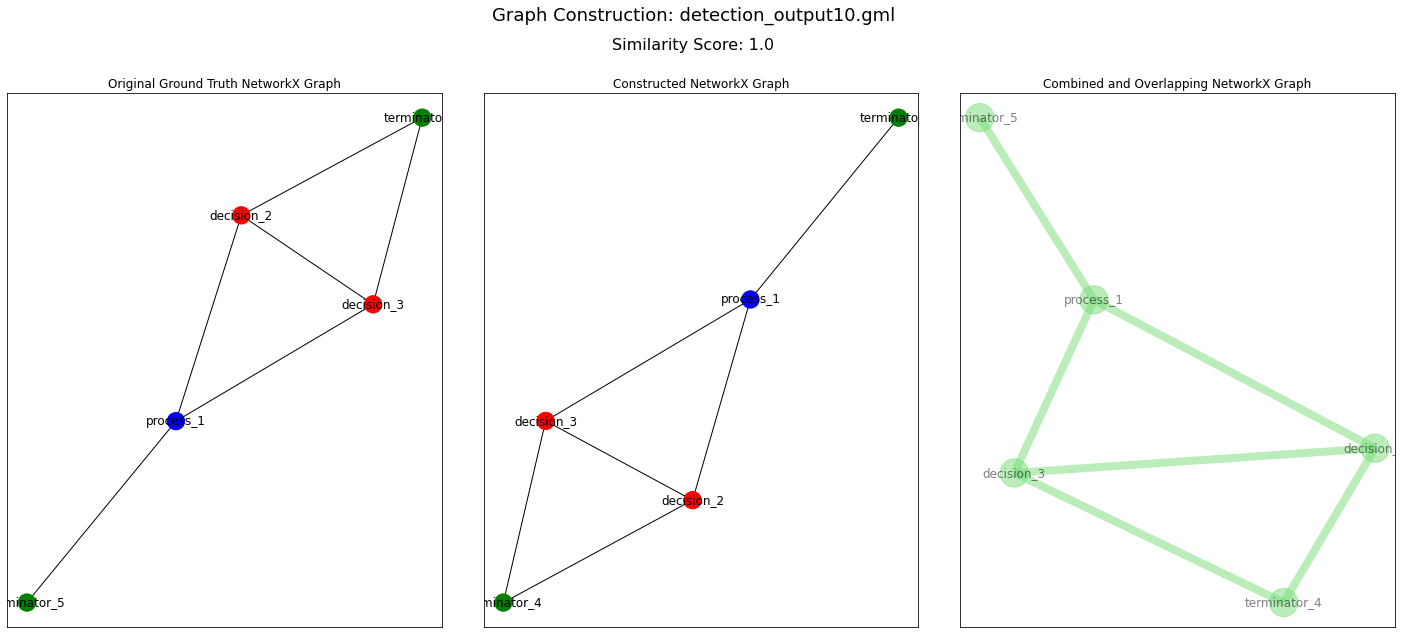

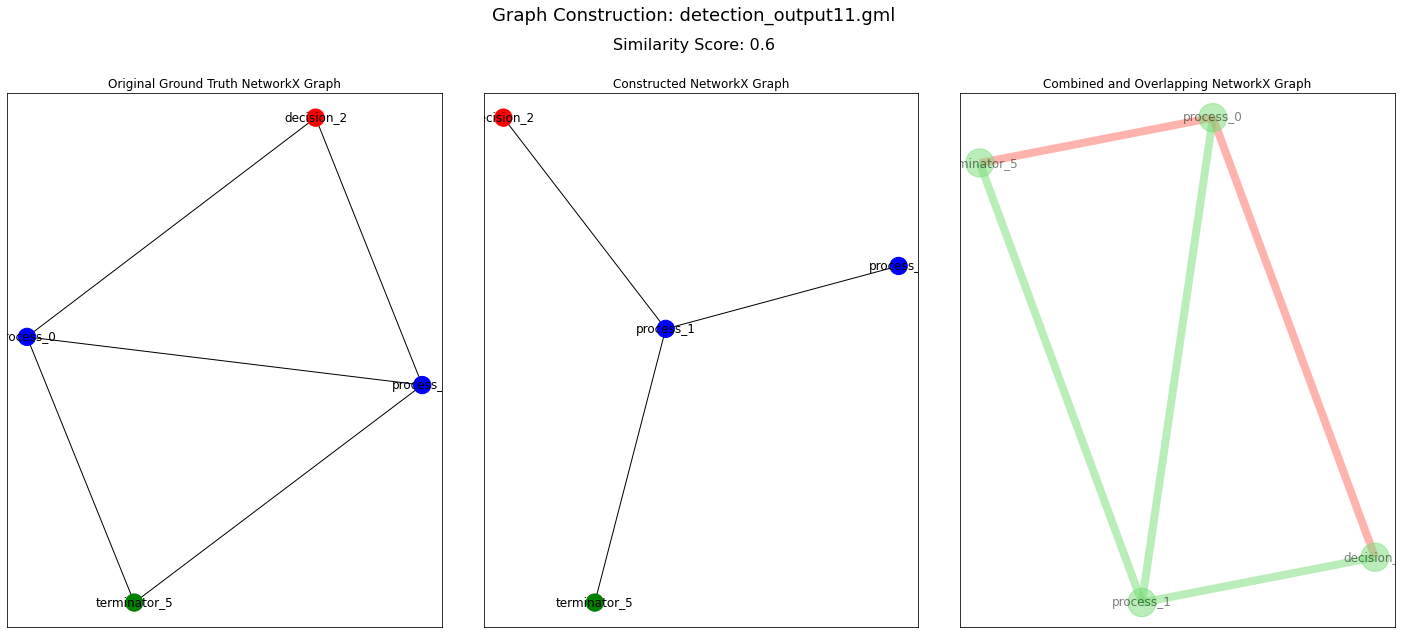

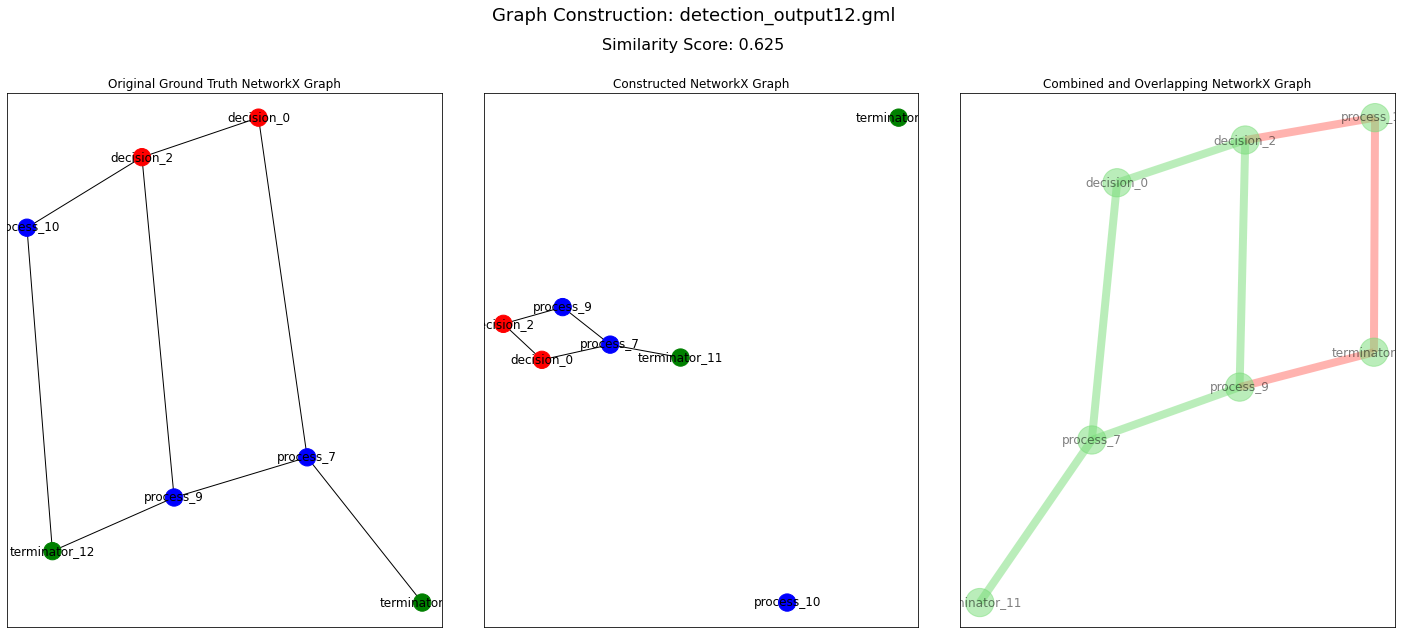

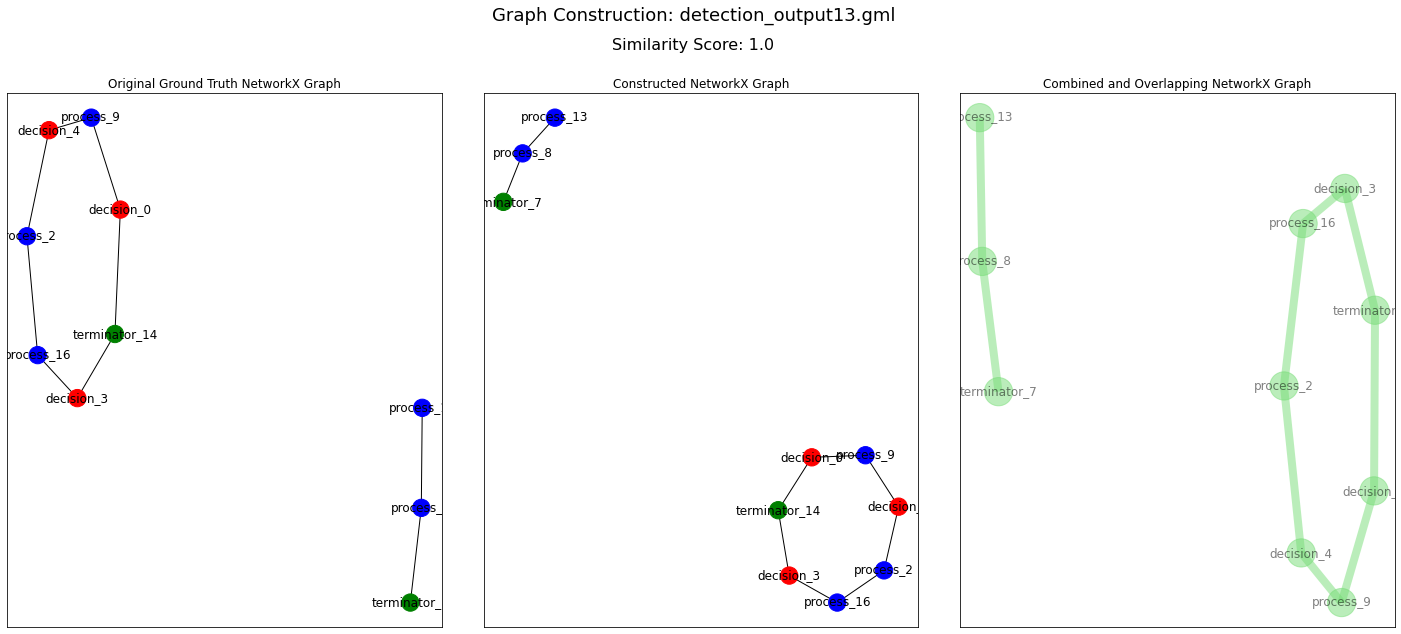

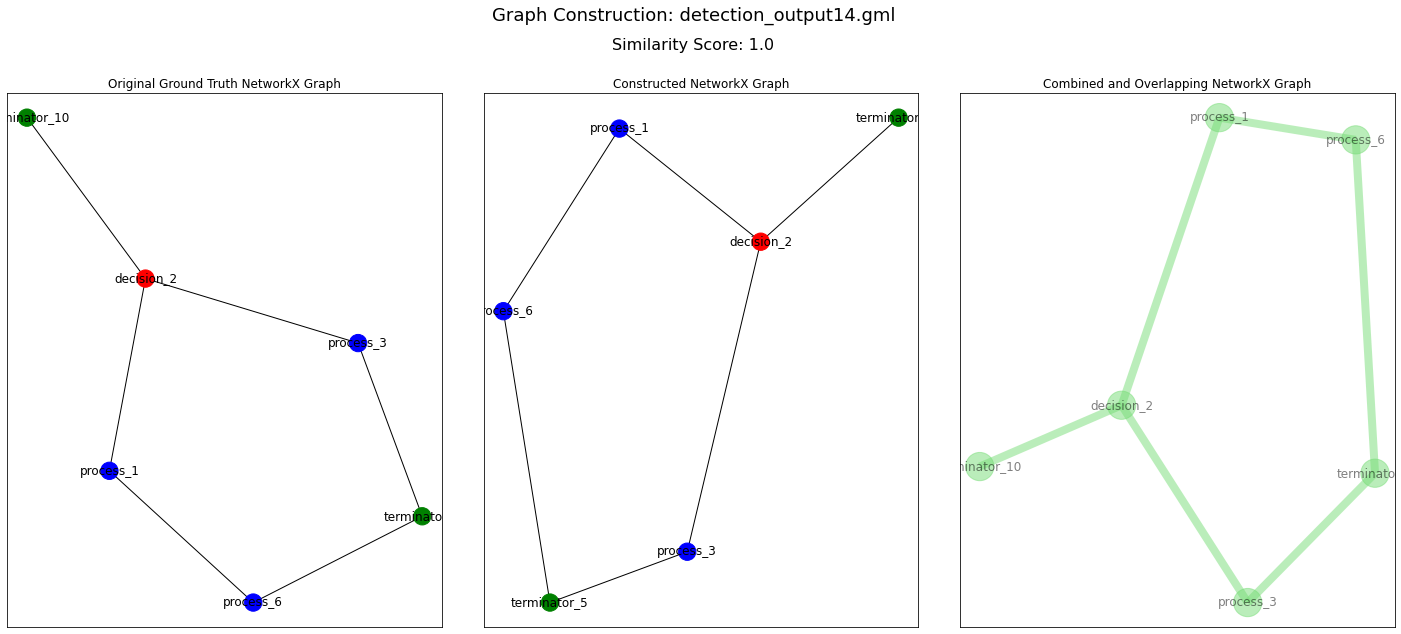

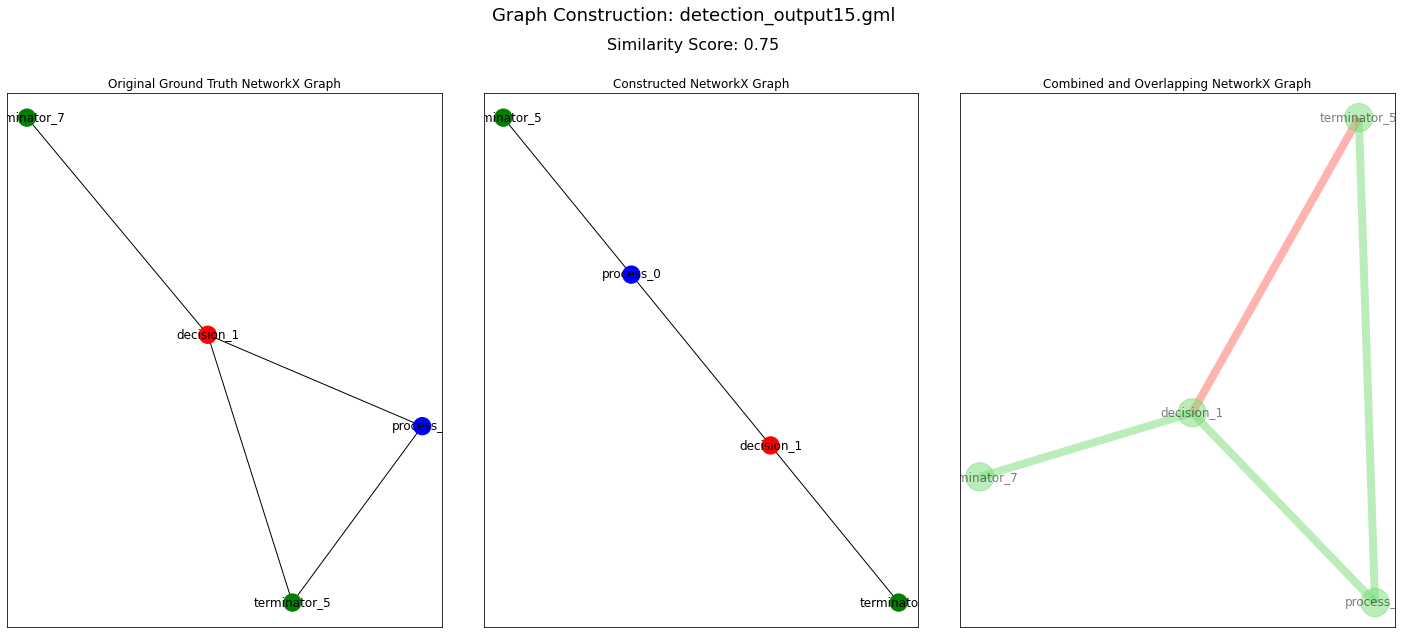

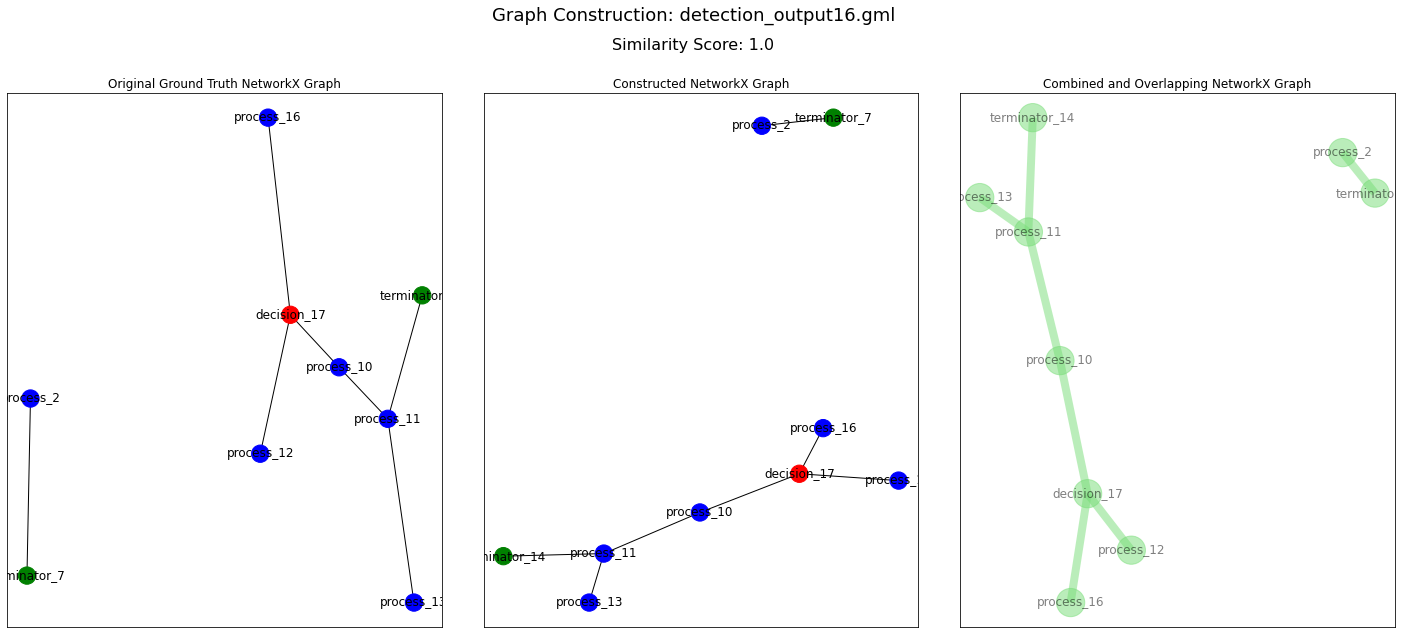

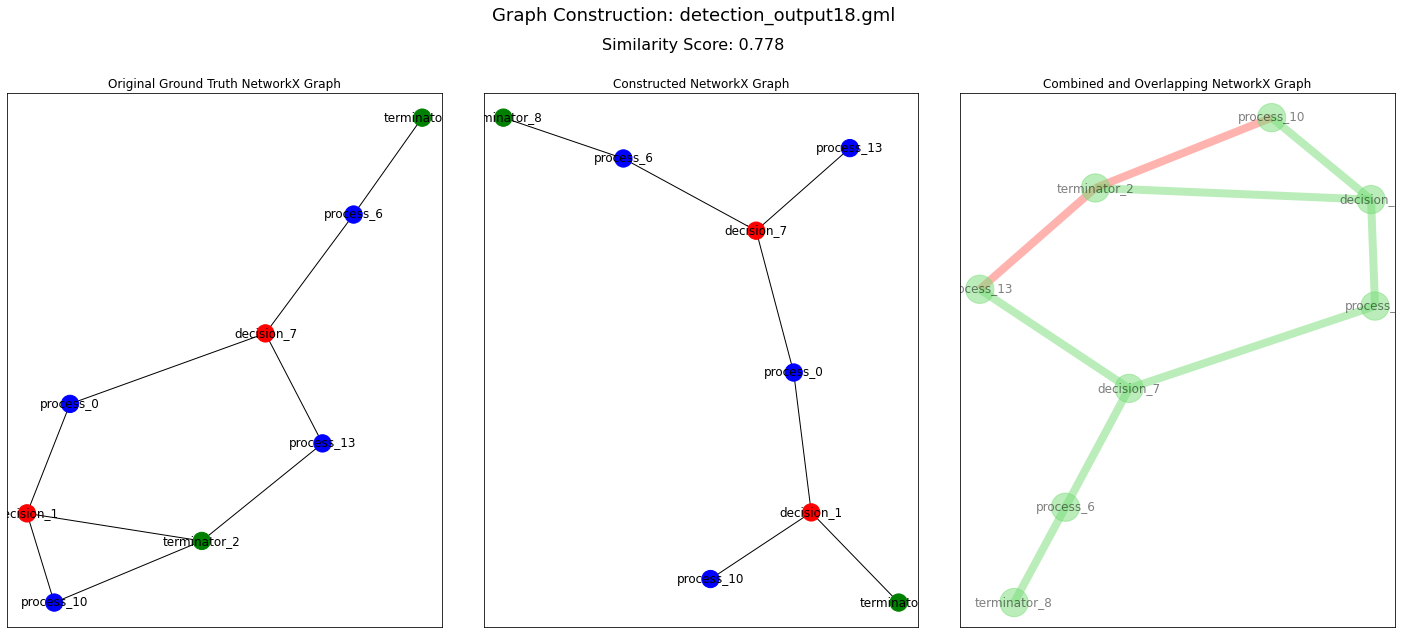

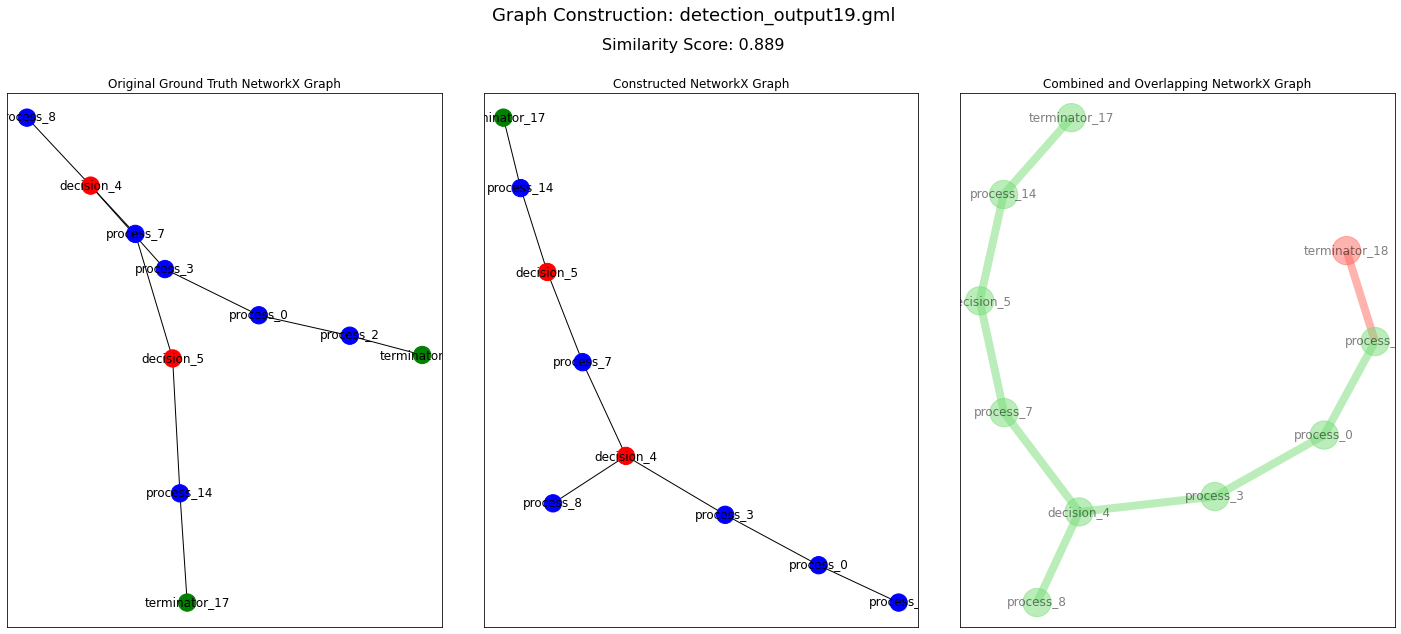

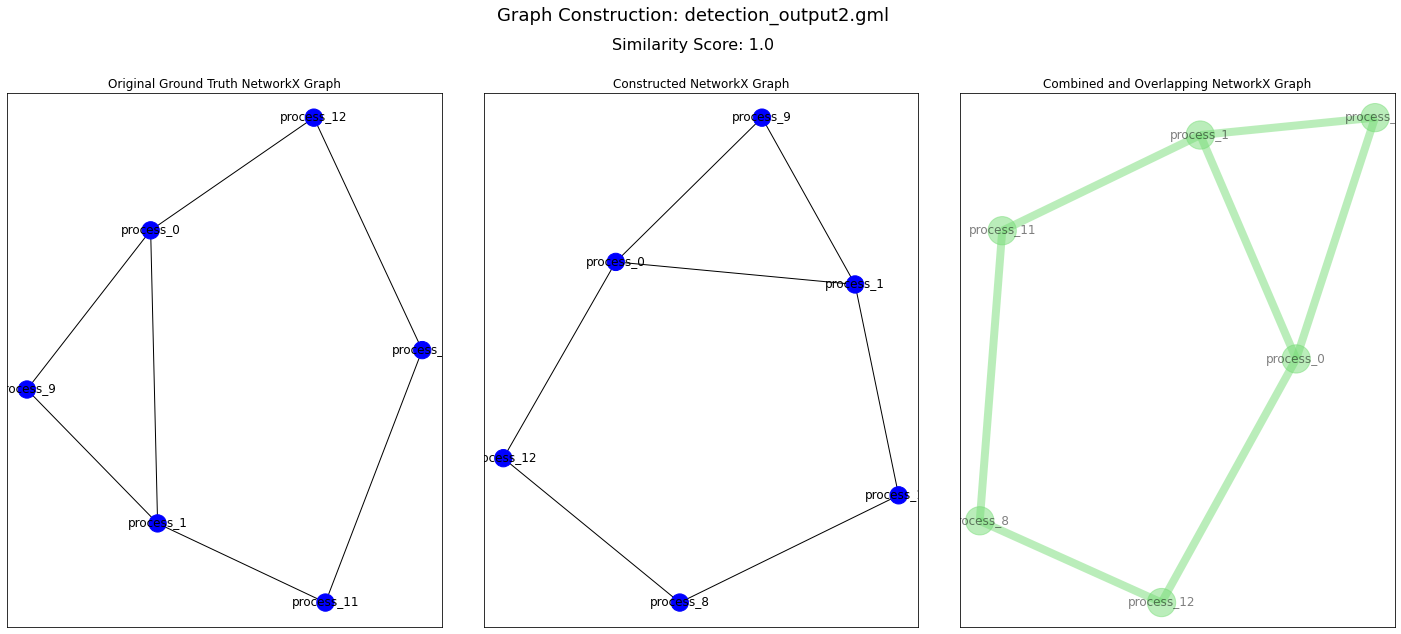

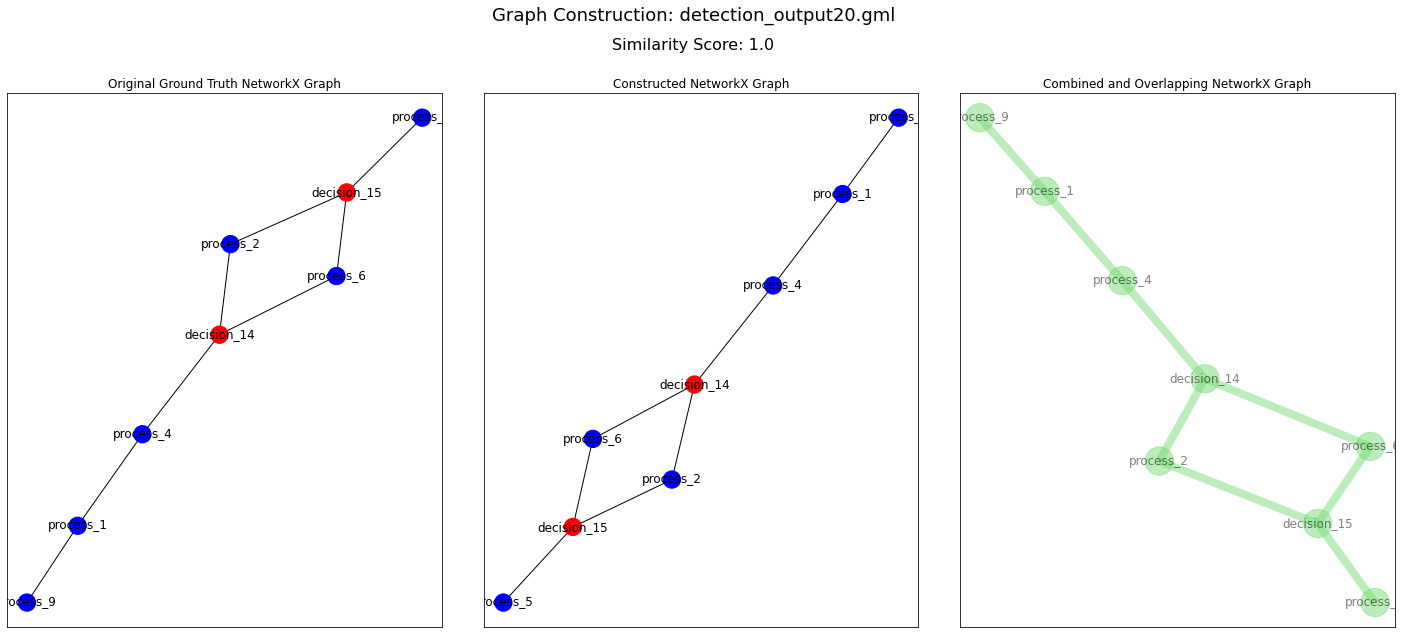

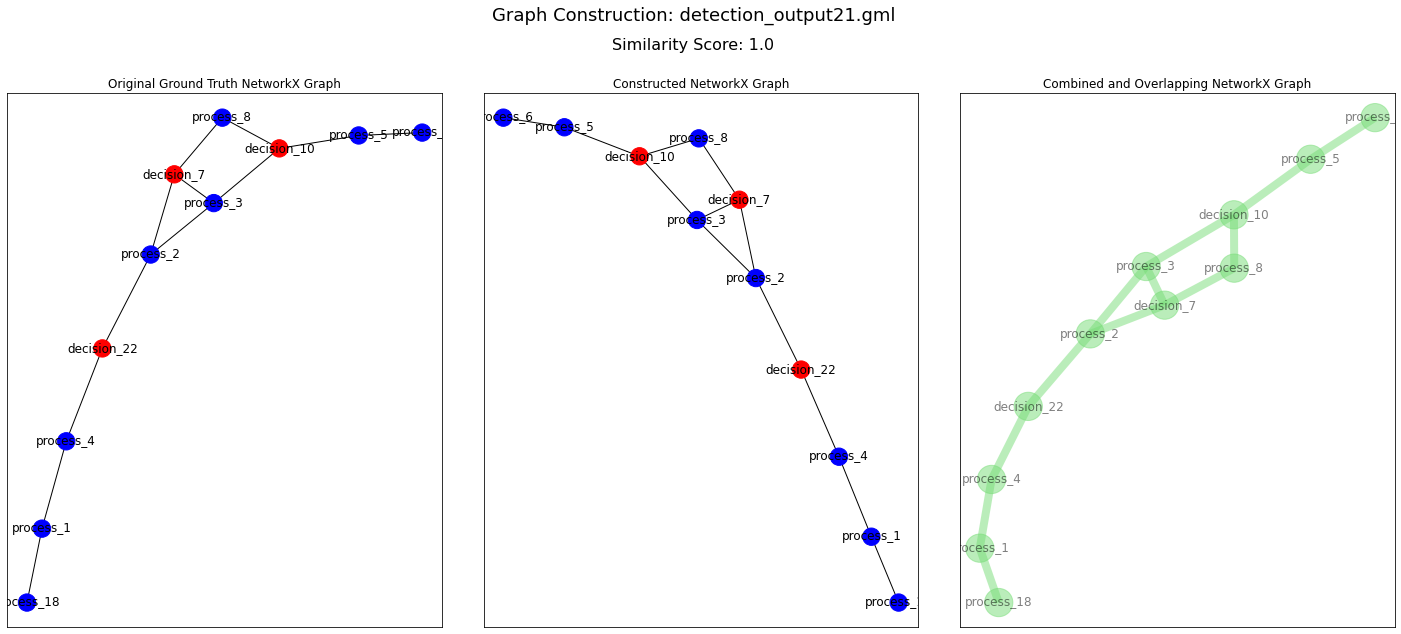

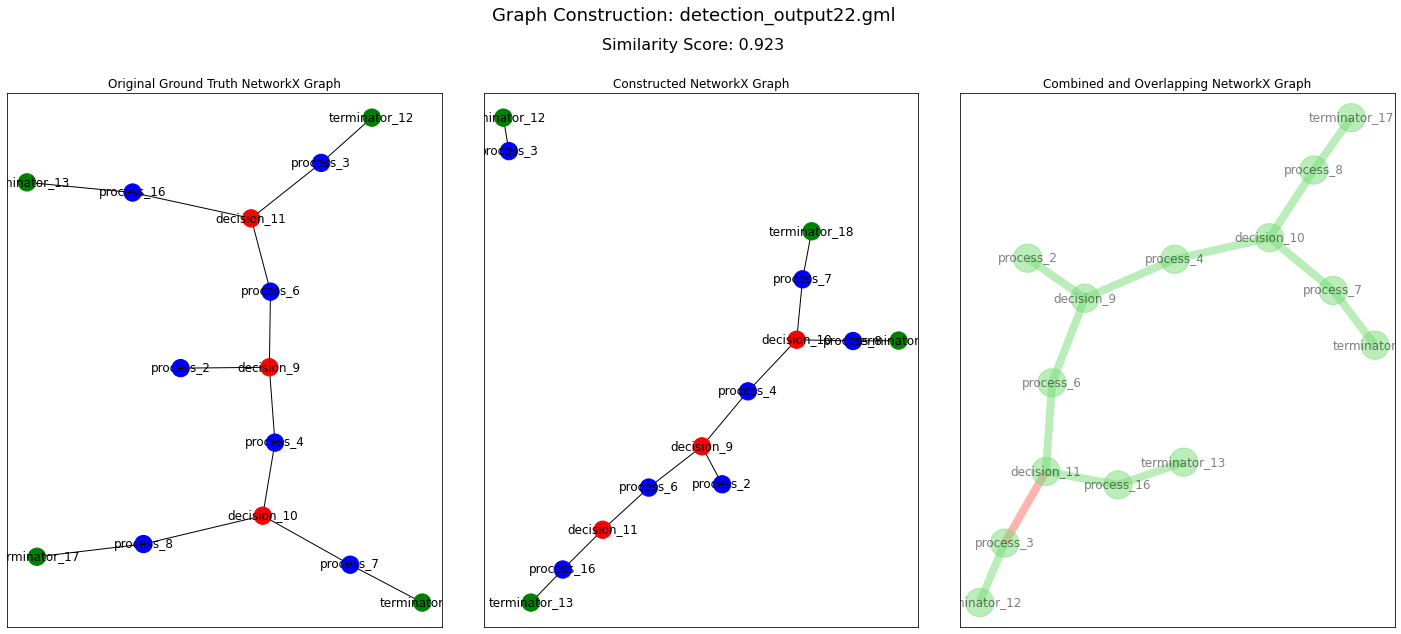

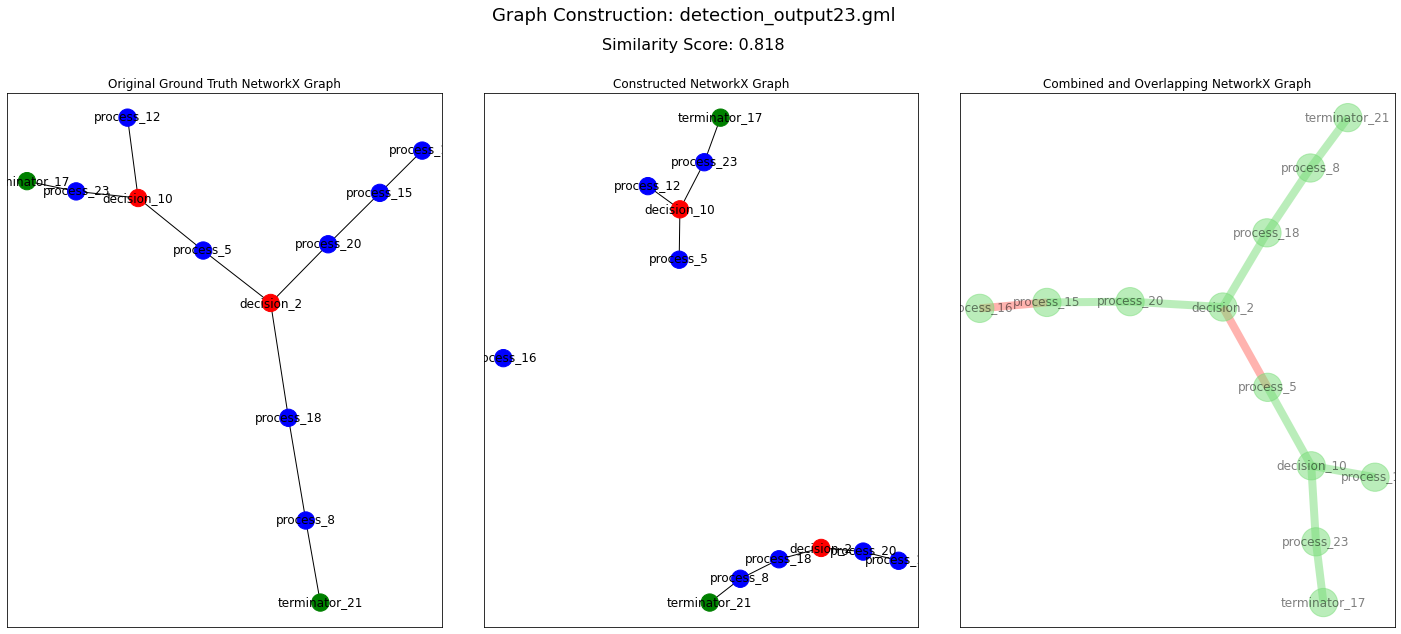

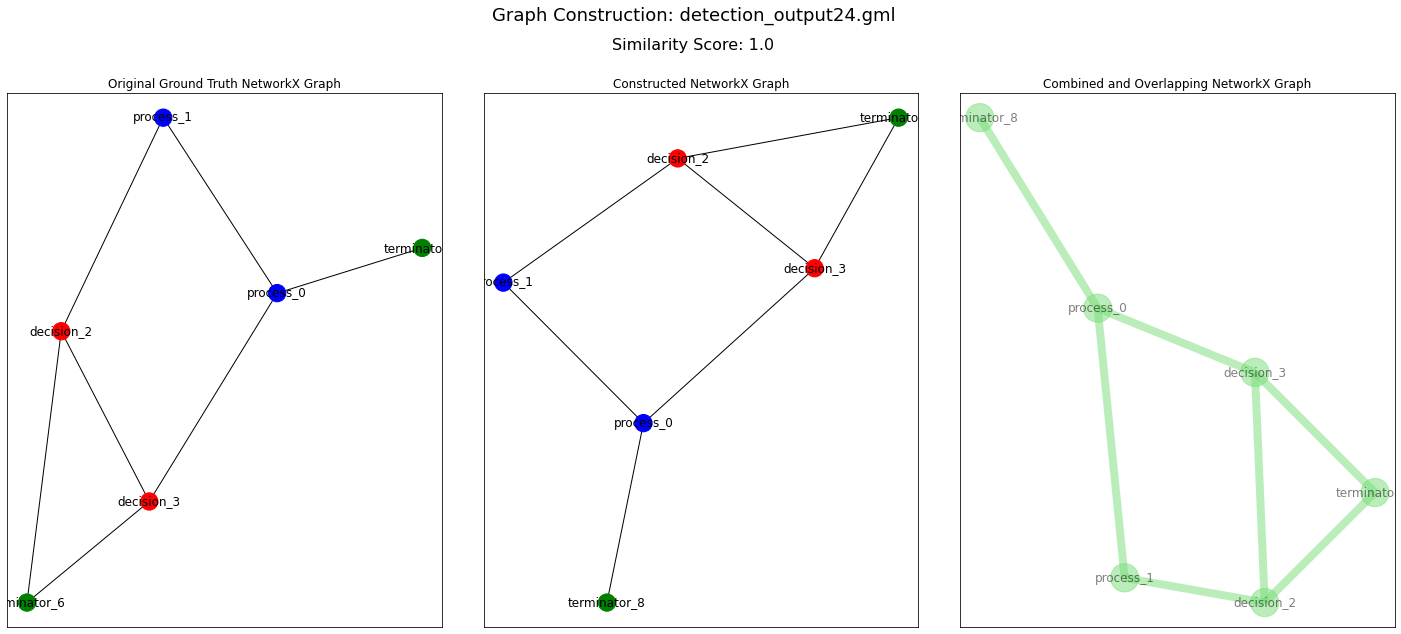

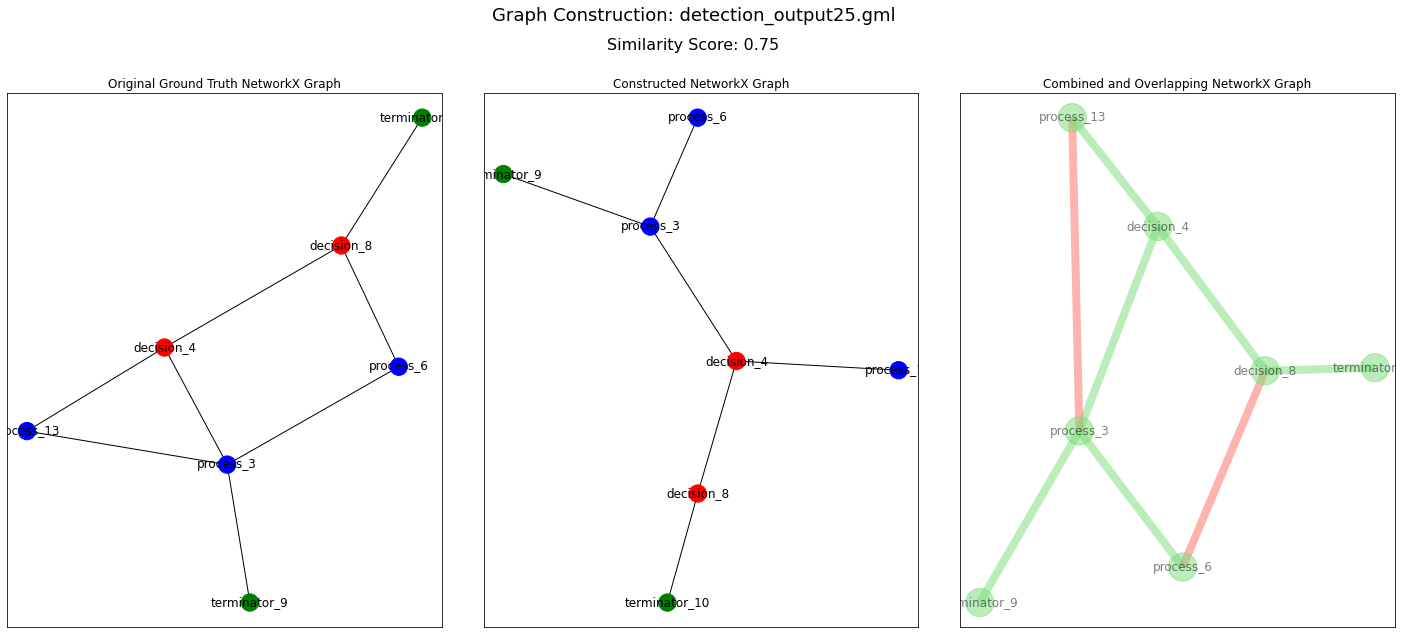

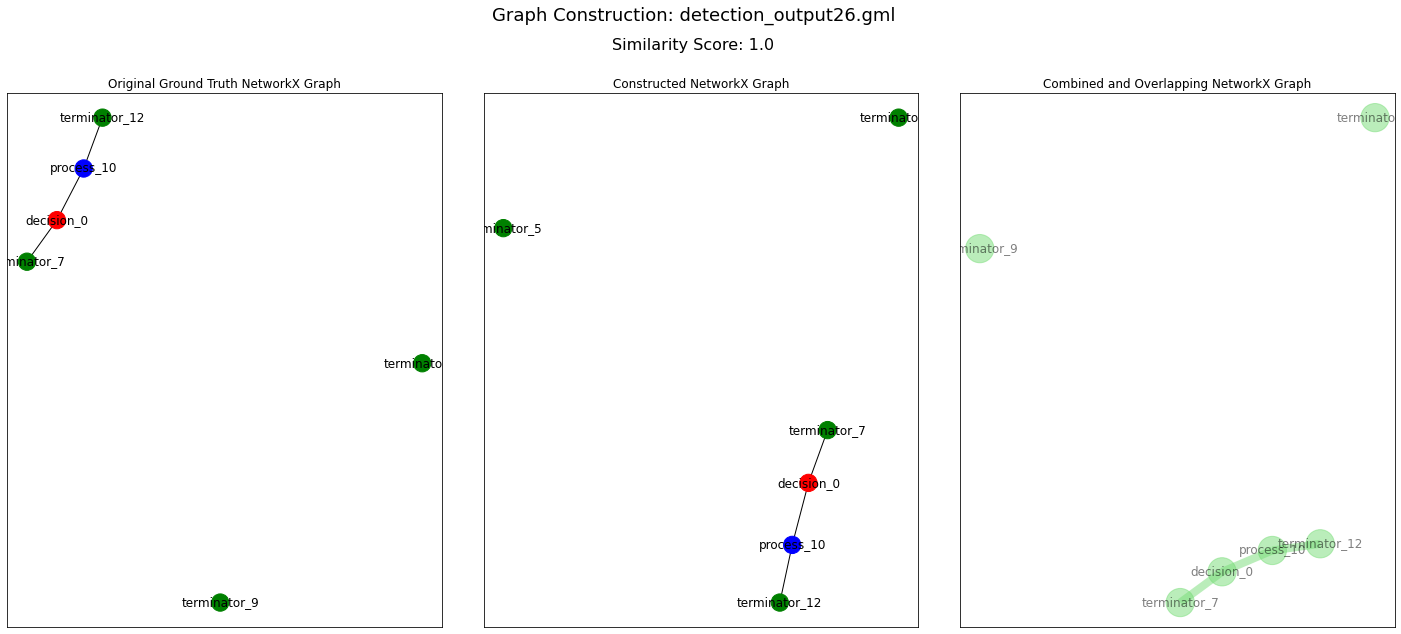

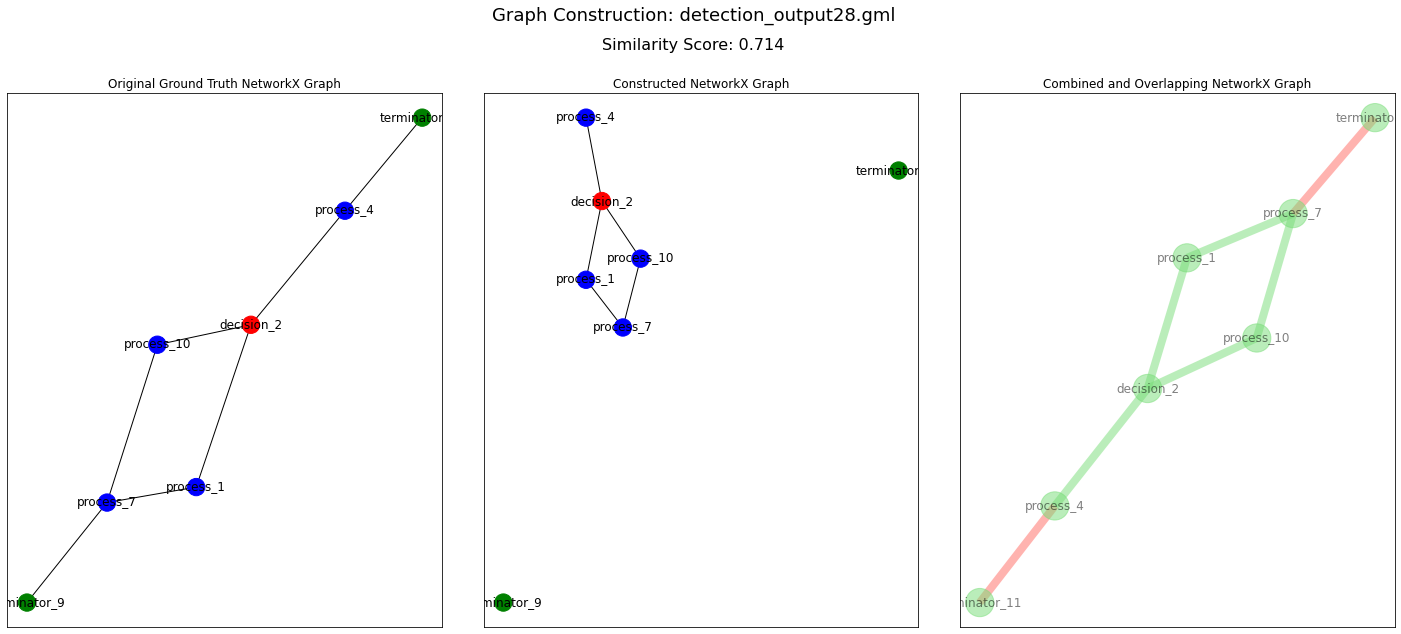

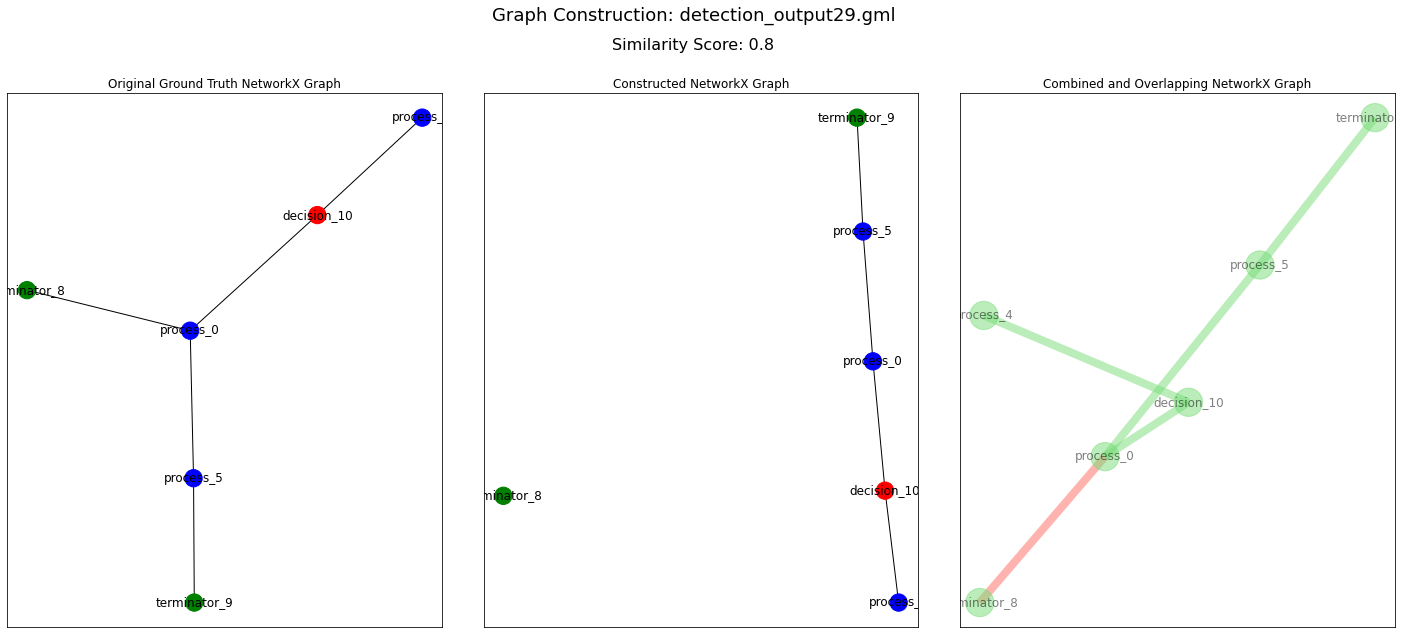

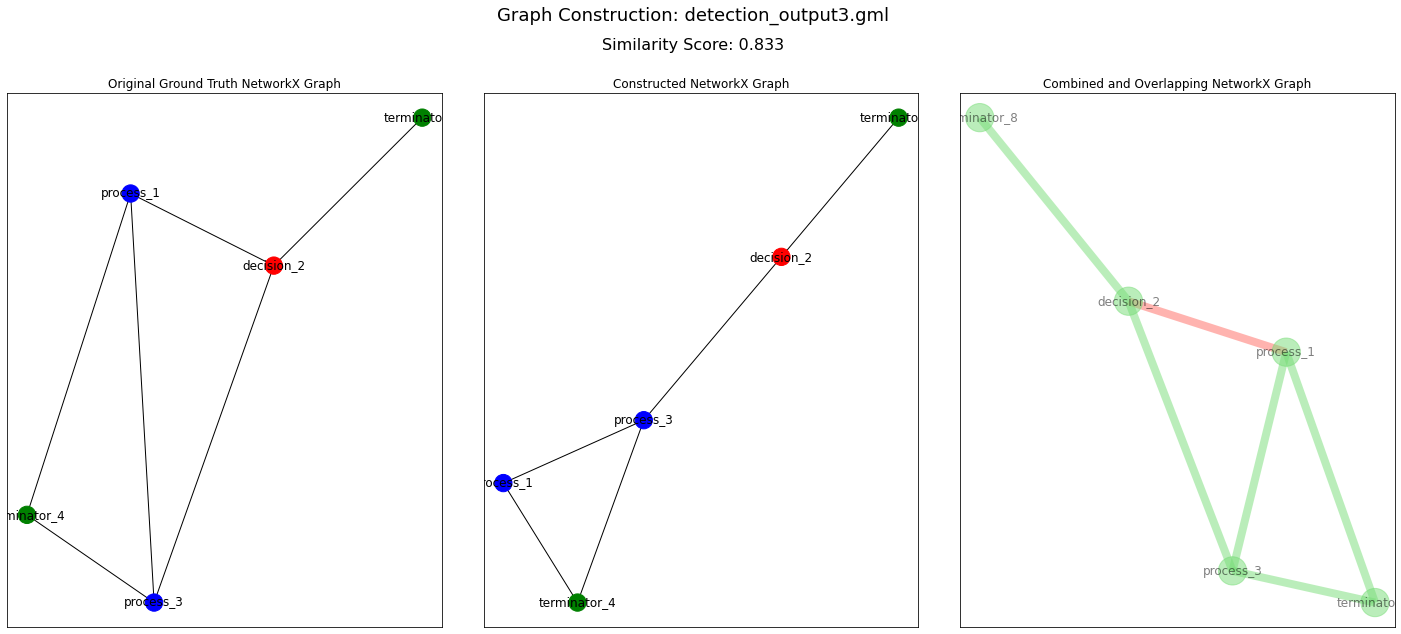

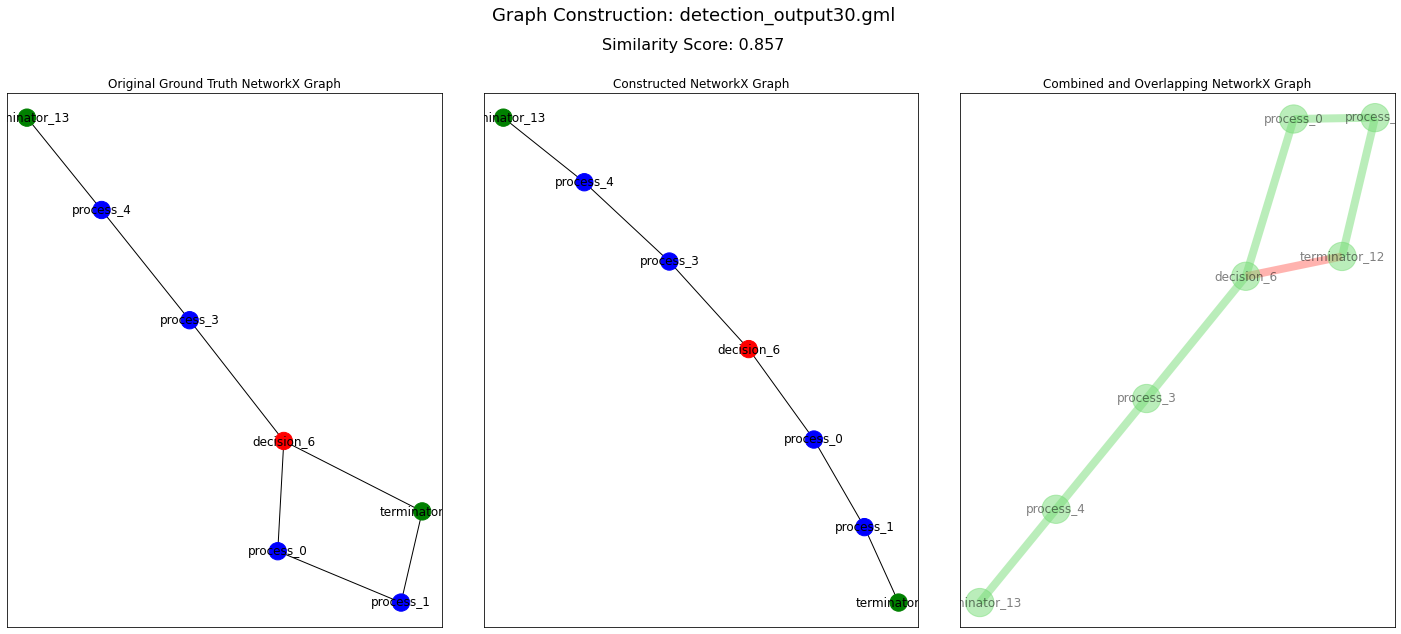

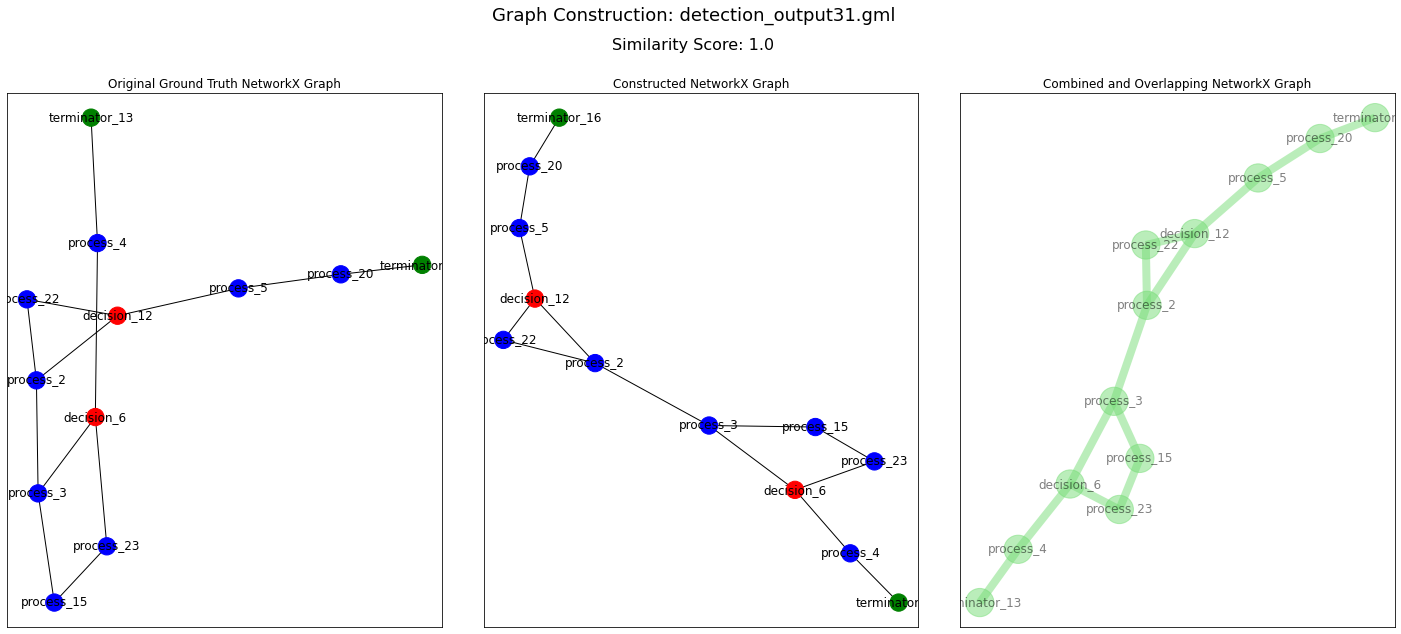

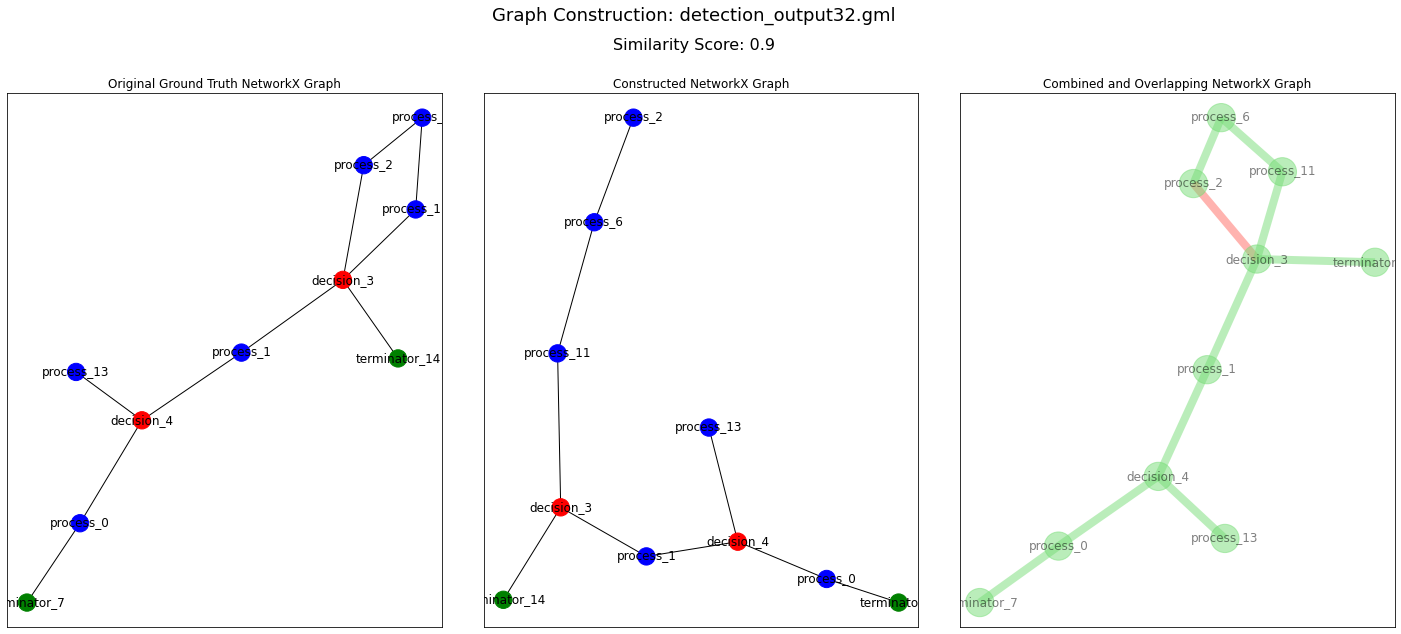

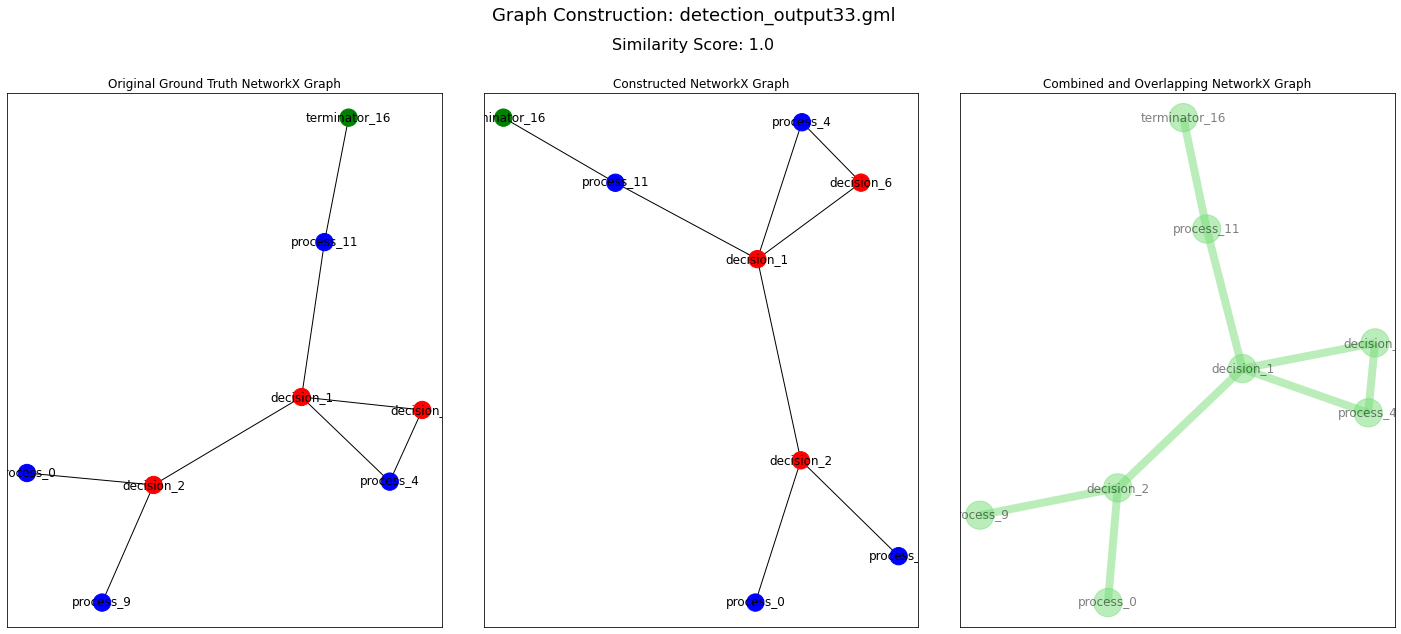

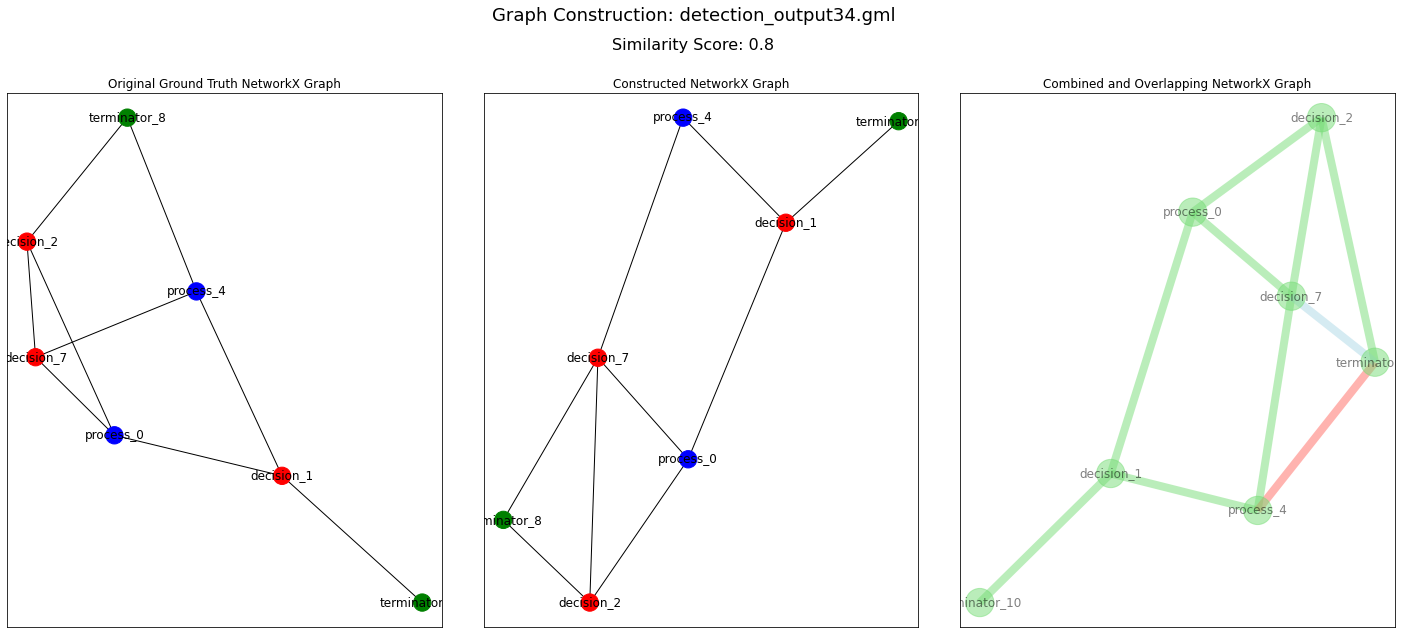

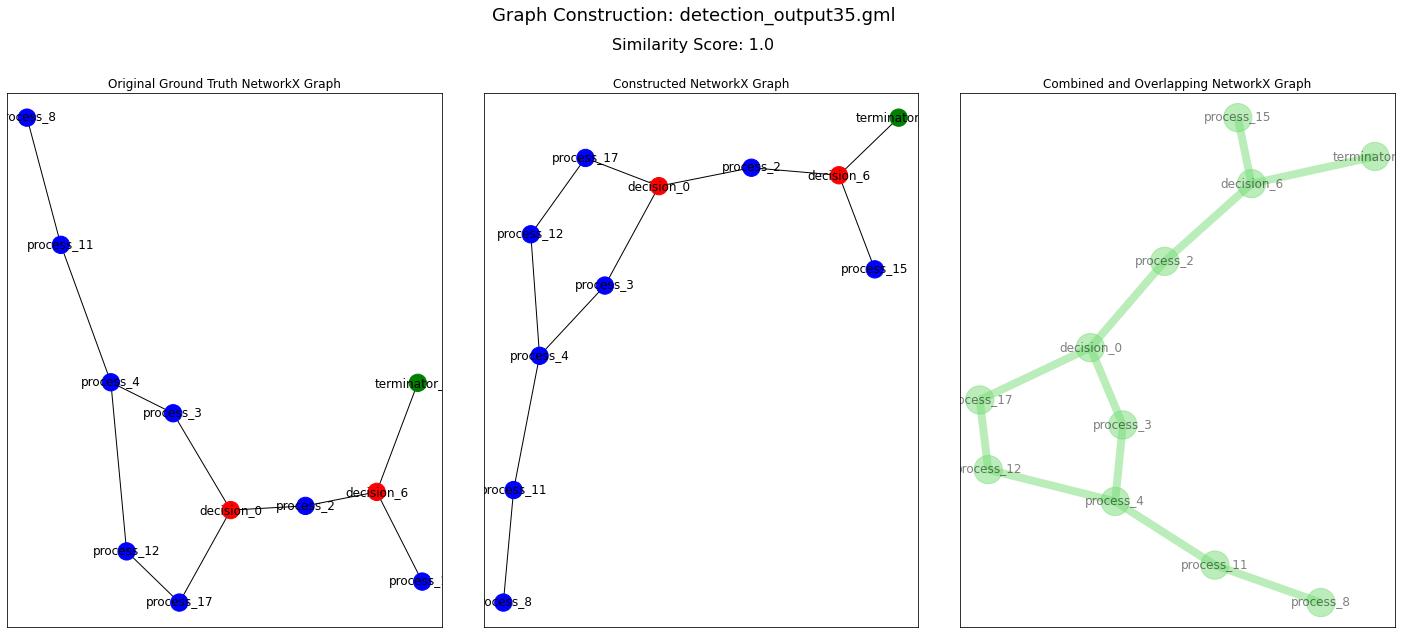

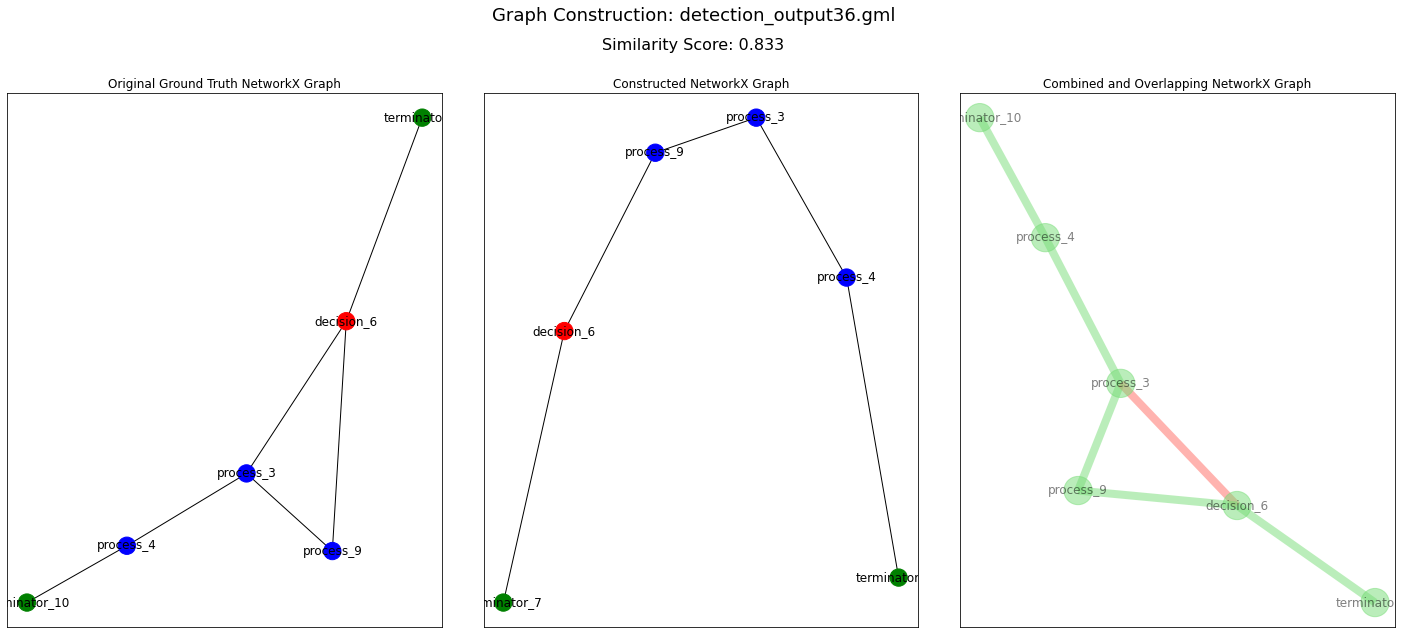

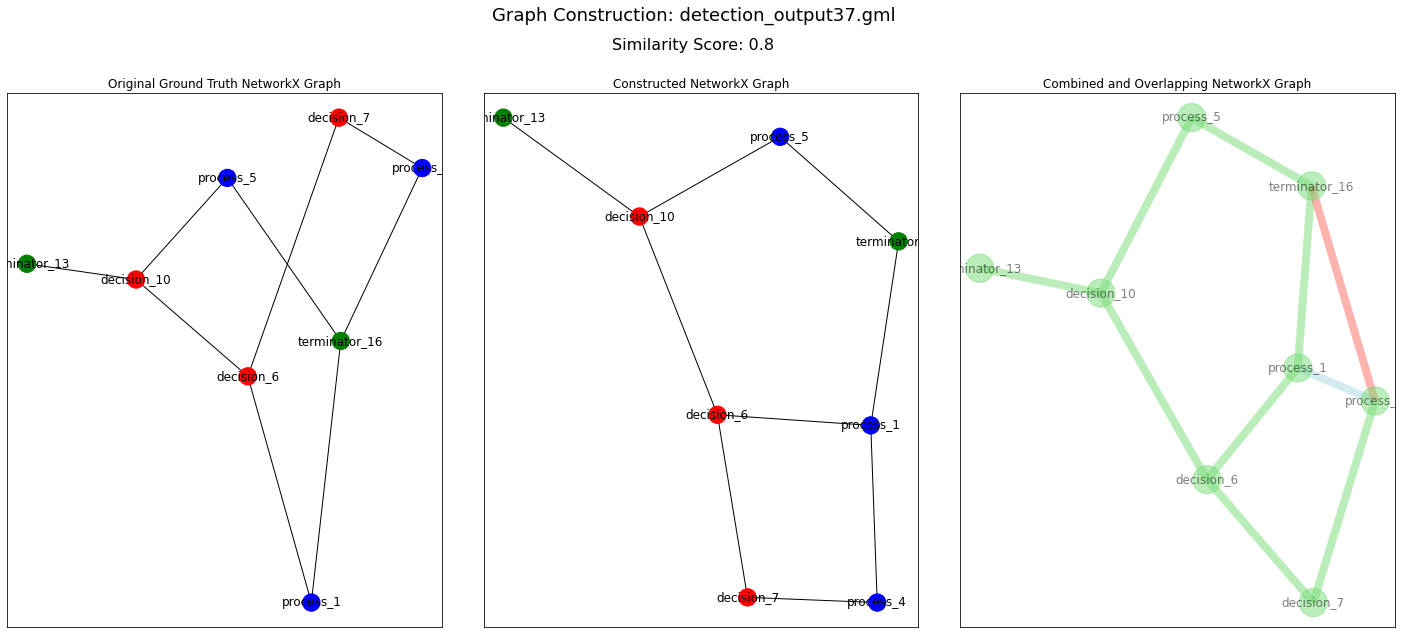

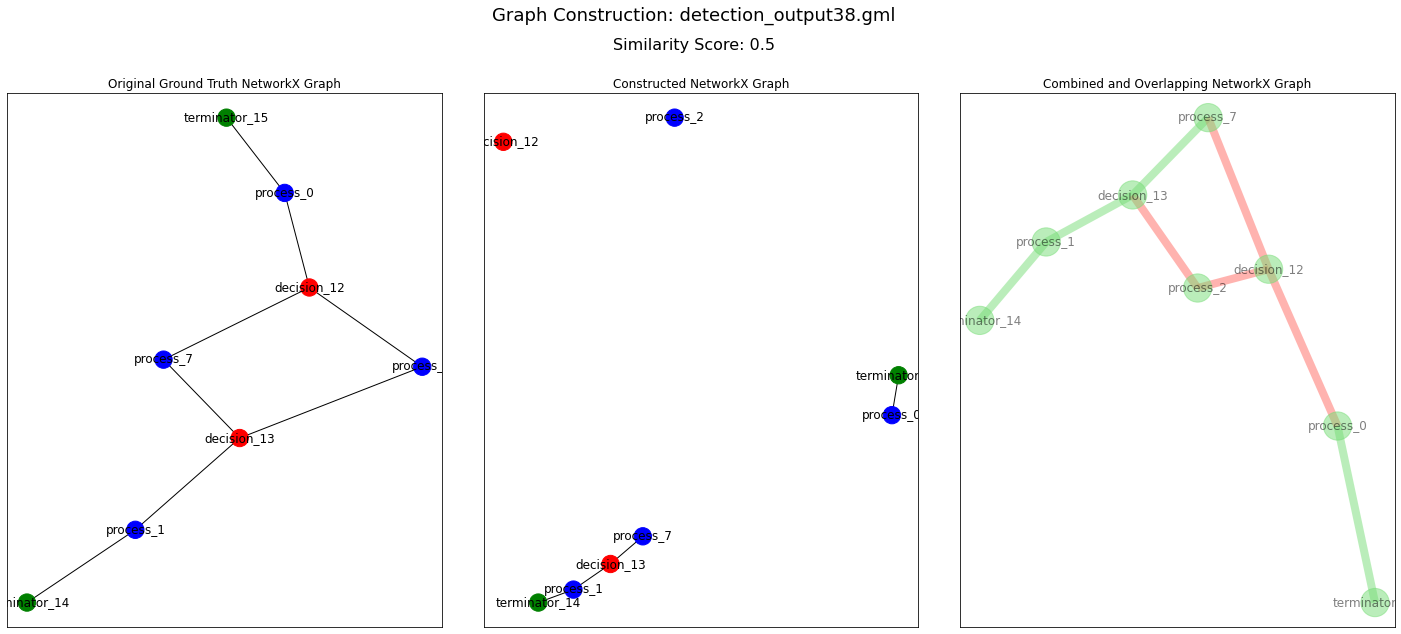

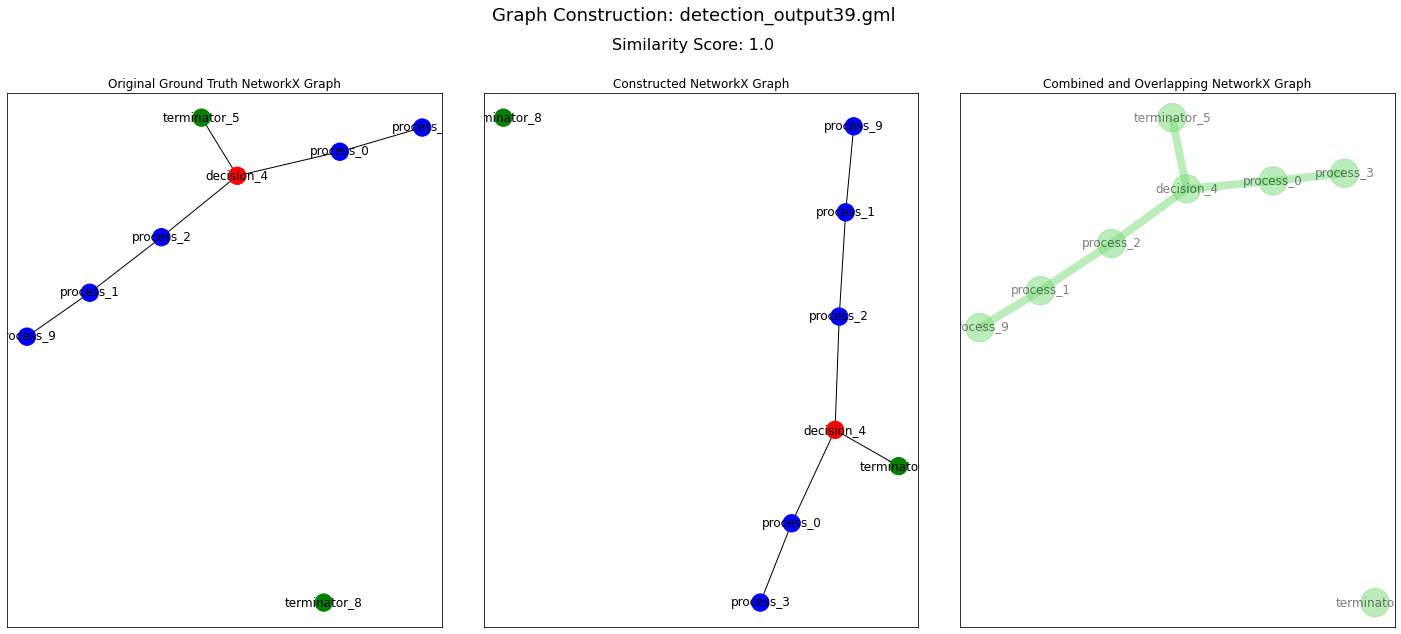

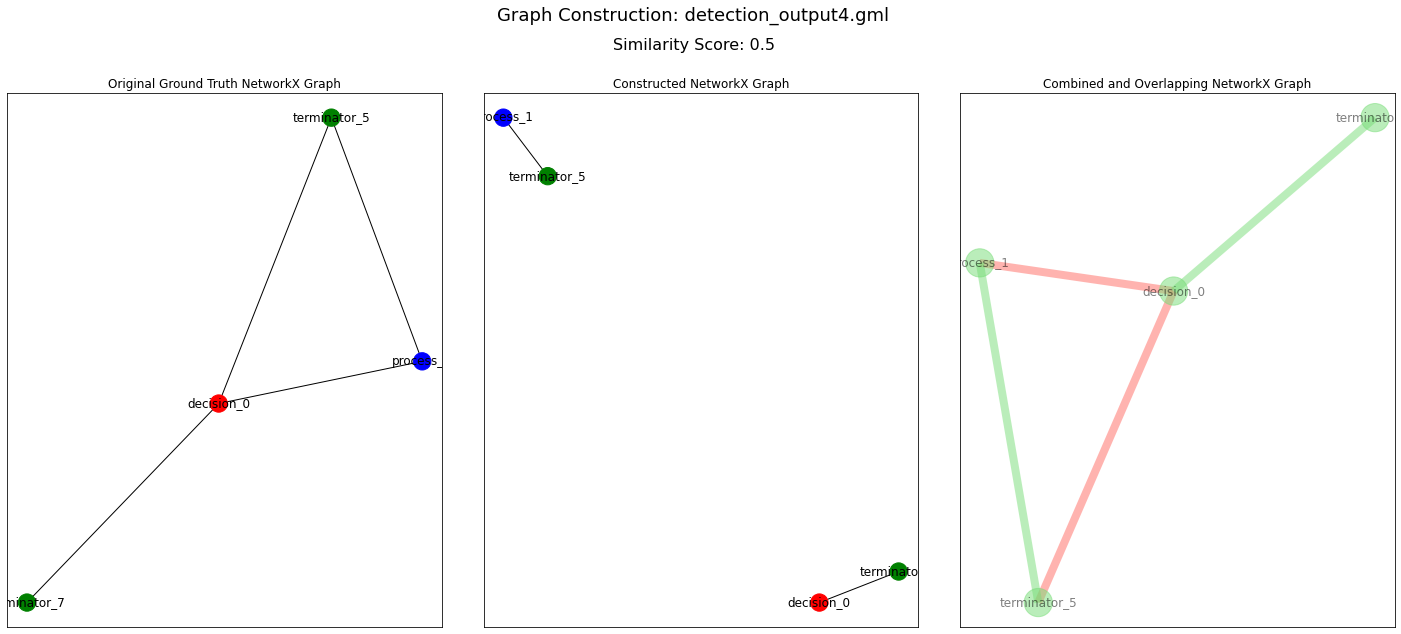

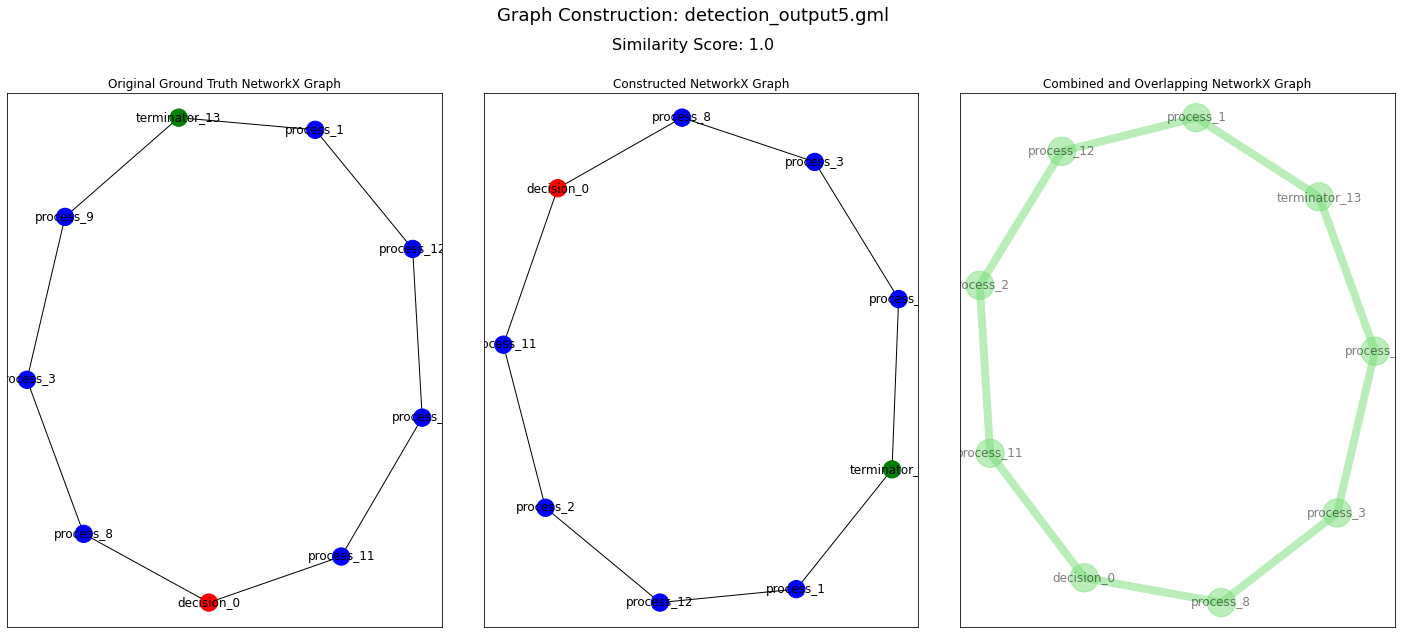

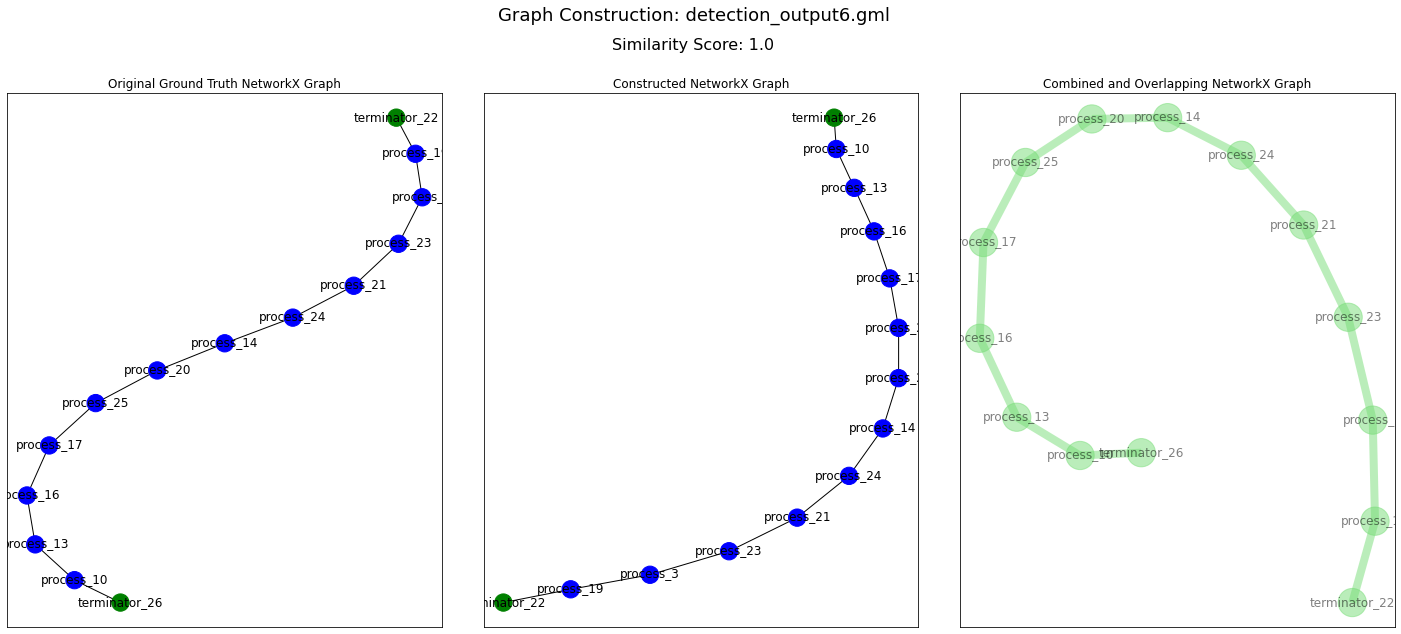

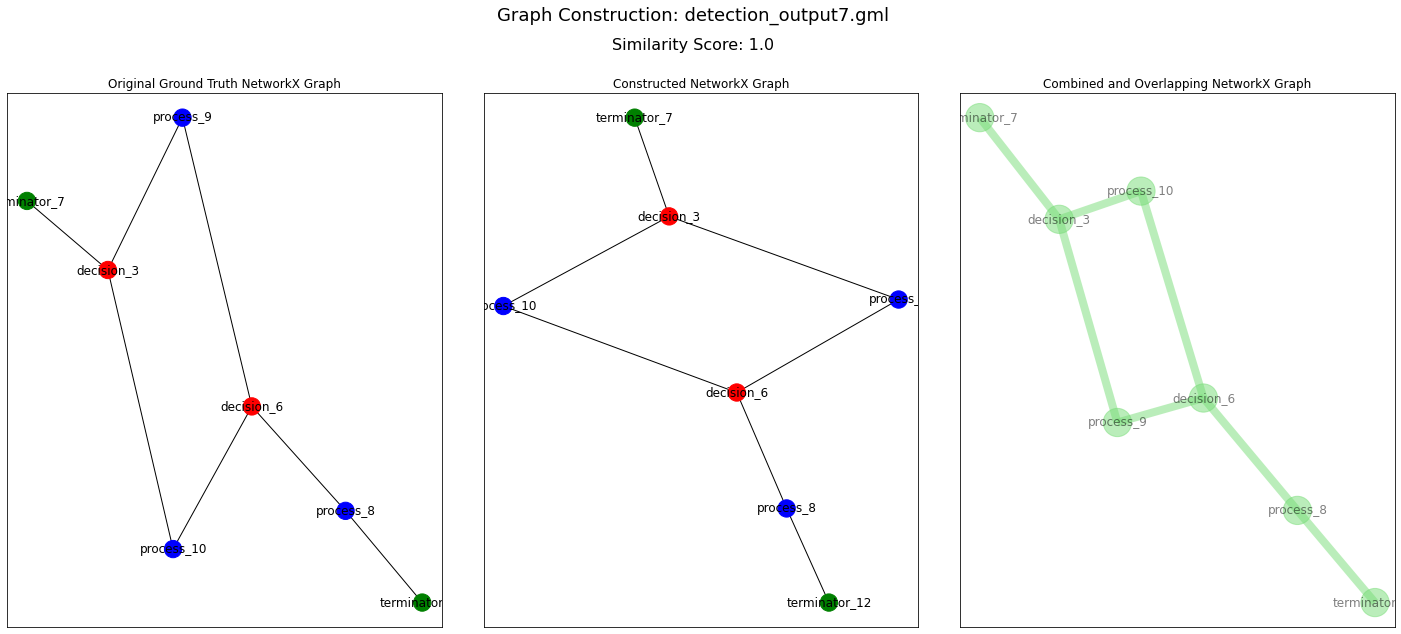

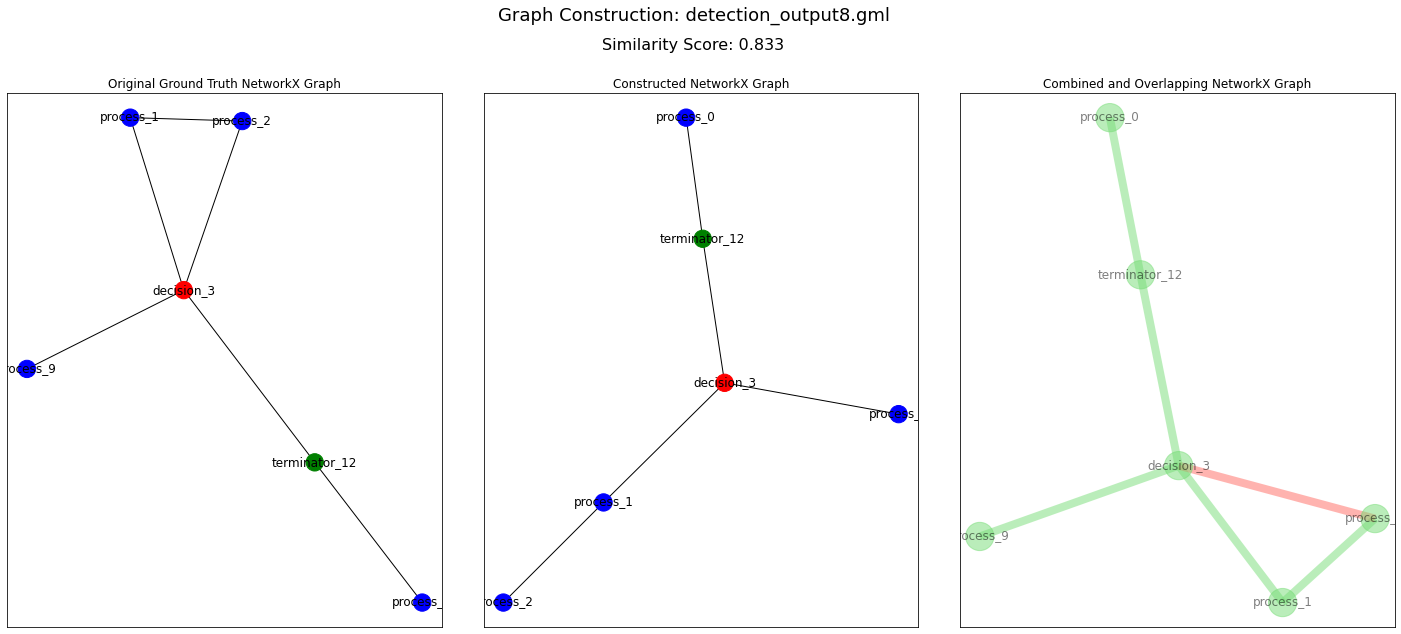

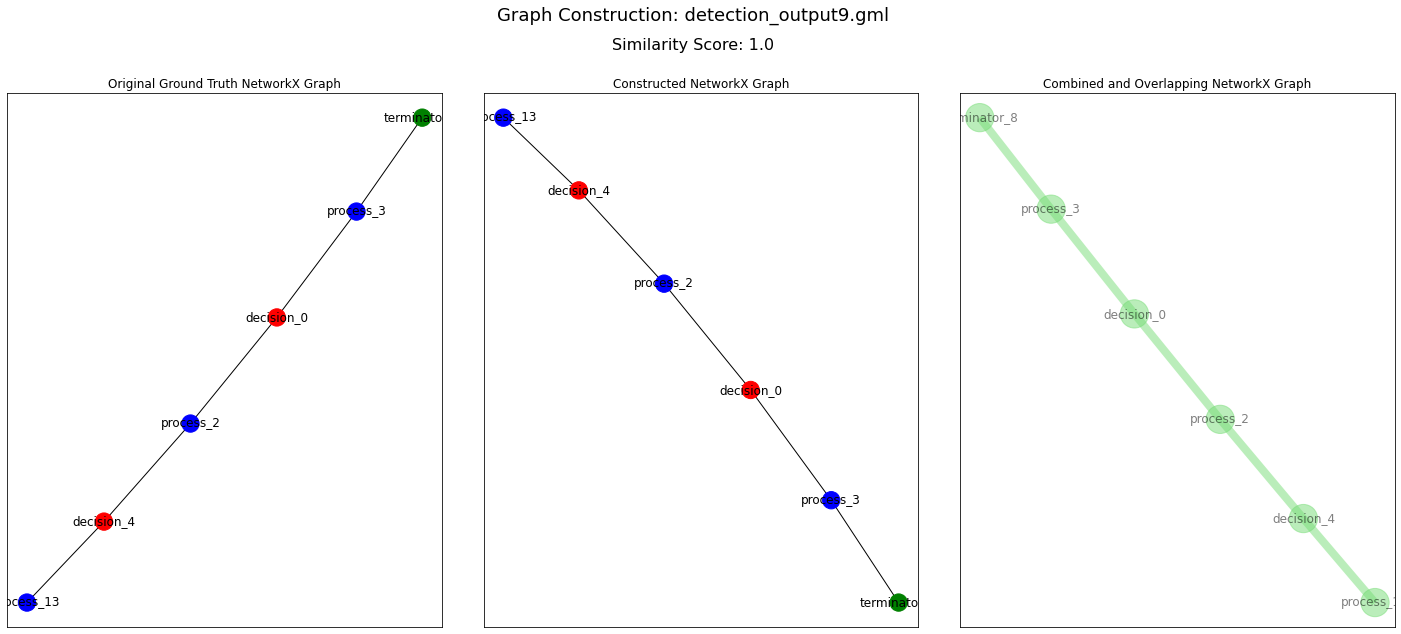

In [ ]:
nx_objs_sorted = sorted(nx_objs, key=lambda x : x[0])
gml.sort()
jaccard_values = []
for fname, (name_const, nx_const) in zip(gml, nx_objs_sorted):
  G = nx.read_gml(CBD_PATH + fname)
  jaccard = jaccard_similarity(G.edges(), nx_const.edges())
  if fname not in ['detection_output0.gml', 'detection_output17.gml', 'detection_output27.gml', 'detection_output1.gml']:
    jaccard_values.append(jaccard)
    GH, node_colors, edge_colors = get_union(G, nx_const)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,8))
    fig.tight_layout()
    plt.figtext(.5,1.1, 'Graph Construction: ' + fname, fontsize=18, ha='center')
    plt.figtext(.5,1.05,"Similarity Score: " + str(jaccard),fontsize=16,ha='center')

    # pos = nx.spring_layout(G, scale=20)
    colored_dict = nx.get_node_attributes(G, 'color')
    default_color = 'blue'
    color_seq = [colored_dict.get(node, default_color) for node in G.nodes()]
    nx.draw_networkx(G,with_labels = True,node_color=color_seq, ax=ax1)
    # ax1.set_axis_off()
    ax1.set_title('Original Ground Truth NetworkX Graph')

    # pos = nx.spring_layout(nx_const, scale=20)
    colored_dict = nx.get_node_attributes(nx_const, 'color')
    default_color = 'blue'
    color_seq = [colored_dict.get(node, default_color) for node in nx_const.nodes()]
    nx.draw_networkx(nx_const,with_labels = True,node_color=color_seq, ax=ax2)
    # ax2.set_axis_off()
    ax2.set_title('Constructed NetworkX Graph')

    # pos = nx.spring_layout(GH, scale=20)
    nx.draw_networkx(GH, 
            nodelist=GH.nodes(),
            node_color=node_colors,
            edgelist=edge_colors.keys(), 
            edge_color=edge_colors.values(),
            node_size=800,
            width=8,alpha=0.5,
            with_labels=True,
            ax=ax3)
    # ax3.set_axis_off()
    ax3.set_title('Combined and Overlapping NetworkX Graph')
    plt.show()
    print("")

In [ ]:
print("Graph Construction Similarity Score: " + str(sum(jaccard_values) / len(jaccard_values)))

Graph Construction Similarity Score: 0.8750833333333331


## GNN Data Construction

In [ ]:
with open("/content/gdrive/My Drive/TF/models/research/object_detection/graph_properties.csv", "w") as out_file_properties:
  with open("/content/gdrive/My Drive/TF/models/research/object_detection/graph_edges.csv", "w") as out_file_edges:
    csv_writer_edges = csv.writer(out_file_edges)
    csv_writer_properties = csv.writer(out_file_properties)

    header_edges = ["graph_id", "src", "dist"]
    header_properties = ["graph_id", "label", "num_nodes"]

    graph_id = 0

    csv_writer_edges.writerow(header_edges)
    csv_writer_properties.writerow(header_properties)

    for g in networkx_objs_bpnm:
      num_nodes = len(g.nodes)
      csv_writer_properties.writerow([graph_id, 0, num_nodes])

      for edge in g.edges():
          csv_writer_edges.writerow([graph_id, edge[0], edge[1]])
        
      graph_id += 1

    for g in networkx_objs_swimlane:   
      num_nodes = len(g.nodes)
      csv_writer_properties.writerow([graph_id, 1, num_nodes])

      for edge in g.edges():
          csv_writer_edges.writerow([graph_id, edge[0], edge[1]])
        
      graph_id += 1     

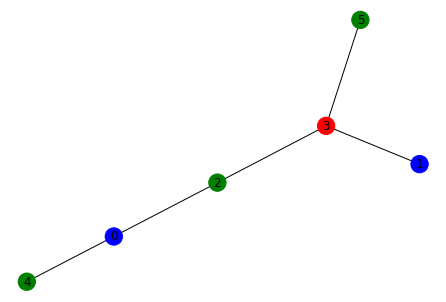

In [ ]:
pos = nx.spring_layout(G)

colored_dict = nx.get_node_attributes(G, 'color')
default_color = 'blue'
color_seq = [colored_dict.get(node, default_color) for node in G.nodes()]

shape_dict = nx.get_node_attributes(G, 'node_shape')
default_shape = 'o'
shape_seq = [shape_dict.get(node, default_shape) for node in G.nodes()]

nx.draw(G,pos,with_labels = True,node_color=color_seq)
plt.show()